**2장 – 머신러닝 프로젝트 처음부터 끝까지**

*머신러닝 부동산 회사에 오신 것을 환영합니다! 여러분이 할 작업은 캘리포니아 지역 주택의 여러 특성을 사용해 중간 가격을 예측하는 것입니다.*

*이 노트북은 2장의 모든 샘플 코드와 연습 문제 정답을 담고 있습니다.*

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

# 설정

먼저 몇 개의 모듈을 임포트합니다. 맷플롯립 그래프를 인라인으로 출력하도록 만들고 그림을 저장하는 함수를 준비합니다. 또한 파이썬 버전이 3.5 이상인지 확인합니다(파이썬 2.x에서도 동작하지만 곧 지원이 중단되므로 파이썬 3을 사용하는 것이 좋습니다). 사이킷런 버전이 0.20 이상인지도 확인합니다.

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 깔금한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 불필요한 경고를 무시합니다 (사이파이 이슈 #5998 참조)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# 데이터 가져오기

In [72]:
import pickle
from bigquery_worker import BigqueryWorker
from IPython.display import display

bigquery_worker = BigqueryWorker()
try:
    with open('datasets/df1.pickle', 'rb') as f:
        df1 = pickle.load(f)
except:
  df1 = bigquery_worker.get_daily_info_all('daily_items_indicator_info_all').drop_duplicates(['itemname', 'date'], 'first')
try:
    with open('datasets/df2.pickle', 'rb') as f:
        df2 = pickle.load(f)
except:
  df2 = bigquery_worker.get_daily_info_all('daily_items_info_all', start_date='2015-09-01').drop_duplicates(['itemname', 'date'], 'first').set_index('itemname')
df3 = bigquery_worker.get_itemcodes_info()

display(df1, df2, df3)

,itemname,date,PER,PBR,PCR,PSR,ROE,ROA,OPROA,OPROE,EV_EBITDA,GP_A,NOS
0,글로본,2016-09-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
1,글로본,2016-09-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2,현대중공업지주,2017-08-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
3,현대중공업지주,2017-05-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
4,글로본,2016-05-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2189280,휴니드테크놀러지스,2016-12-16,133.168,2.202,NaN,NaN,1.63,0.78,1.28,2.668,NaN,0.0,181144600.0
2189281,휴니드테크놀러지스,2016-11-01,132.178,2.186,NaN,NaN,1.63,0.78,1.28,2.668,NaN,0.0,179797800.0
2189282,휴니드테크놀러지스,2016-11-22,131.683,2.177,NaN,NaN,1.63,0.78,1.28,2.668,NaN,0.0,179124400.0
2189283,휴니드테크놀러지스,2016-08-22,164.356,2.718,NaN,NaN,1.63,0.78,1.28,2.668,NaN,0.0,223568800.0


,date,open,high,low,close,volume
itemname,,,,,,
S&K폴리텍,2018-01-02,5600,5680,5530,5640,95035
씨큐브,2018-01-02,6570,6673,6268,6546,32283
조이맥스,2018-01-02,10600,11300,10450,11150,26139
지엔씨에너지,2018-01-02,4120,4140,4080,4130,86541
한전기술,2018-01-02,23300,23550,23000,23350,166043
...,...,...,...,...,...,...
금강공업,2020-11-06,4350,4405,4330,4390,57473
경보제약,2020-11-06,10100,10150,9940,10000,49710
한컴MDS,2020-11-06,12300,12300,12000,12150,57767


,itemcode,itemname,market,sector,main_product,listing_date,settlement_month,representative_name,homepage,area
0,950140,잉글우드랩,kosdaq,기타 화학제품 제조업,기초화장품(화장품 제조),2016-10-14,12월,조현철,http://www.englewoodlab.com,미국
1,900100,뉴프라이드,kosdaq,자동차 부품 및 내장품 판매업,인터모달 신생 및 재생타이어,2010-04-21,12월,John Lee,http://www.npcims.com,미국
2,950200,소마젠,kosdaq,"그외 기타 전문, 과학 및 기술 서비스업","유전체 분석 서비스 (NGS, CES 등)",2020-07-13,12월,Ryan W. Kim (김운봉),None,미국
3,950160,코오롱티슈진,kosdaq,기초 의약물질 및 생물학적 제제 제조업,골관절염 치료제,2017-11-06,12월,"노문종, 한성수",http://tissuegene.com,미국
4,950130,엑세스바이오,kosdaq,의료용품 및 기타 의약 관련제품 제조업,"말라리아 진단키트(RDT), HIV 진단키트(RDT)",2013-05-30,12월,최영호,http://www.accessbio.net,미국
...,...,...,...,...,...,...,...,...,...,...
2238,006220,제주은행,kospi,은행 및 저축기관,"은행업무,외국환업무,신탁업무",1972-12-28,12월,서현주,http://www.e-jejubank.com,제주특별자치도
2239,089590,제주항공,kospi,항공 여객 운송업,"여객운송서비스, 화물운송서비스",2015-11-06,12월,김이배,http://www.jejuair.net,제주특별자치도
2240,066110,한프,kosdaq,컴퓨터 및 주변장치 제조업,OPC Drum,2002-07-16,12월,유한성,http://www.baiksanopc.co.kr,제주특별자치도
2241,032350,롯데관광개발,kospi,여행사 및 기타 여행보조 서비스업,"국내외여행알선,관광개발,전세운수,항공권매매대행",2006-06-08,12월,"김기병, 백현, 김한준",http://lottetour.com,제주특별자치도


In [3]:
with open('./pickles/df1.pickle', 'wb') as f:
    pickle.dump(df1, f)
with open('./pickles/df2.pickle', 'wb') as f:
    pickle.dump(df2, f)

FileNotFoundError: [Errno 2] No such file or directory: './pickles/df1.pickle'

In [3]:
import pandas as pd

In [4]:
display(df1.info(), df2.info(), df3.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2189285 entries, 0 to 2189284
Data columns (total 13 columns):
itemname     object
date         datetime64[ns]
PER          float64
PBR          float64
PCR          float64
PSR          float64
ROE          float64
ROA          float64
OPROA        float64
OPROE        float64
EV_EBITDA    float64
GP_A         float64
NOS          float64
dtypes: datetime64[ns](1), float64(11), object(1)
memory usage: 233.8+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 1471221 entries, S&K폴리텍 to 디에이테크놀로지
Data columns (total 6 columns):
date      1471221 non-null datetime64[ns]
open      1471221 non-null int64
high      1471221 non-null int64
low       1471221 non-null int64
close     1471221 non-null int64
volume    1471221 non-null int64
dtypes: datetime64[ns](1), int64(5)
memory usage: 78.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2243 entries, 0 to 2242
Data columns (total 10 columns):
itemcode               2243 non-null object
item

None

None

None

In [5]:
import numpy as np

for c in ['market', 'sector', 'main_product', 'settlement_month', 'representative_name', 'homepage', 'area']:
  display(df3[c].value_counts())

kosdaq    1446
kospi      797
Name: market, dtype: int64

특수 목적용 기계 제조업      136
소프트웨어 개발 및 공급업     119
전자부품 제조업           119
자동차 신품 부품 제조업       92
기타 금융업              90
                  ... 
시장조사 및 여론조사업         1
철도장비 제조업             1
재 보험업                1
기타 전문 서비스업           1
해체, 선별 및 원료 재생업      1
Name: sector, Length: 152, dtype: int64

기업인수합병                      38
지주회사                        18
지주사업                         9
화장품                          7
모바일게임                        7
                            ..
금융보험/부동산 임대                  1
침대                           1
계면활성제,정밀화학품 제조,도매/부동산 임대     1
채권추심, 신용조사                   1
그랑파제, 토비콤-S                  1
Name: main_product, Length: 2081, dtype: int64

12월    2188
03월      22
06월      19
09월       5
11월       4
02월       2
08월       2
07월       1
Name: settlement_month, dtype: int64

김상우               4
김영달               3
박세철               3
김성진               3
김영주               3
                 ..
이범호               1
이병용               1
신환률, 김대권(각자대표)    1
주승화               1
강희석               1
Name: representative_name, Length: 2136, dtype: int64

http://www.ildong.com           2
http://imt@kmaringroup.com      2
http://www.jeilpharm.co.kr      2
http://www.greencross.com       2
http://www.sempio.com           2
                               ..
http://www.sspharm.co.kr        1
http://www.mgamecorp.com        1
http://www.hsecure.co.kr        1
http://www.powerlogics.co.kr    1
http://www.gopowernet.com       1
Name: homepage, Length: 2054, dtype: int64

서울특별시      904
경기도        631
충청남도        89
경상남도        89
인천광역시       80
부산광역시       74
충청북도        73
대구광역시       55
경상북도        54
대전광역시       45
전라북도        27
울산광역시       25
강원도         20
전라남도        19
광주광역시       18
제주특별자치도      9
세종특별자치시      9
홍콩           9
케이맨 제도       5
미국           5
일본           3
Name: area, dtype: int64

In [6]:
display(df1.describe().apply(lambda s: s.apply(lambda x: format(x, 'g'))), df2.describe().apply(lambda s: s.apply(lambda x: format(x, 'g'))), df3.describe())

,PER,PBR,PCR,PSR,ROE,ROA,OPROA,OPROE,EV_EBITDA,GP_A,NOS
count,2.18466e+06,2.18466e+06,1.76218e+06,1.76218e+06,2.17223e+06,2.17223e+06,2.18469e+06,2.18469e+06,1.6149e+06,2.18928e+06,2.18469e+06
mean,16.2127,2.12629,9.21668,8.79628,-0.621679,0.763942,2.75985,4.27738,46.3465,0.116997,7.72757e+08
std,239.316,6.98365,344.575,241.186,53.9308,17.0323,9.72121,112.166,410.95,0.193752,7.304e+09
min,-8110,-13.333,-26350,0,-2598.73,-735.63,-365.714,-2800,0,-1.415,0
25%,-3.376,0.732,2.547,0.462,-3.23,-1.6,0,0,7.31,0,6.35542e+07
50%,9.469,1.229,8.01,1.04,4.36,2.38,3.084,5.634,11.66,0.06,1.18933e+08
75%,22.563,2.279,17.422,2.397,10.54,6.21,6.796,12.557,23.23,0.169,2.77256e+08
max,11817.7,922.414,26650,24850,3599.36,718.45,168.924,14133.3,20000.3,3.235,4.02484e+11


,open,high,low,close,volume
count,1.47122e+06,1.47122e+06,1.47122e+06,1.47122e+06,1.47122e+06
mean,21430.2,21836.1,21027.8,21520.3,740223
std,63162.5,64121.5,62220.7,63145.2,4.32768e+06
min,0,0,0,107,0
25%,2700,2770,2635,2785,30099
50%,6150,6300,6020,6210,108631
75%,16150,16500,15750,16200,370475
max,1.749e+06,1.749e+06,1.692e+06,1.749e+06,8.51967e+08


,itemcode,itemname,market,sector,main_product,listing_date,settlement_month,representative_name,homepage,area
count,2243,2243,2243,2243,2225,2243,2243,2243,2076,2243
unique,2243,2243,2,152,2081,1670,8,2136,2054,21
top,011280,미래에셋맵스리츠,kosdaq,특수 목적용 기계 제조업,기업인수합병,1976-06-30 00:00:00,12월,김상우,http://www.ildong.com,서울특별시
freq,1,1,1446,136,38,8,2188,4,2,904
first,NaN,NaN,NaN,NaN,NaN,1956-03-03 00:00:00,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,2020-11-06 00:00:00,NaN,NaN,NaN,NaN


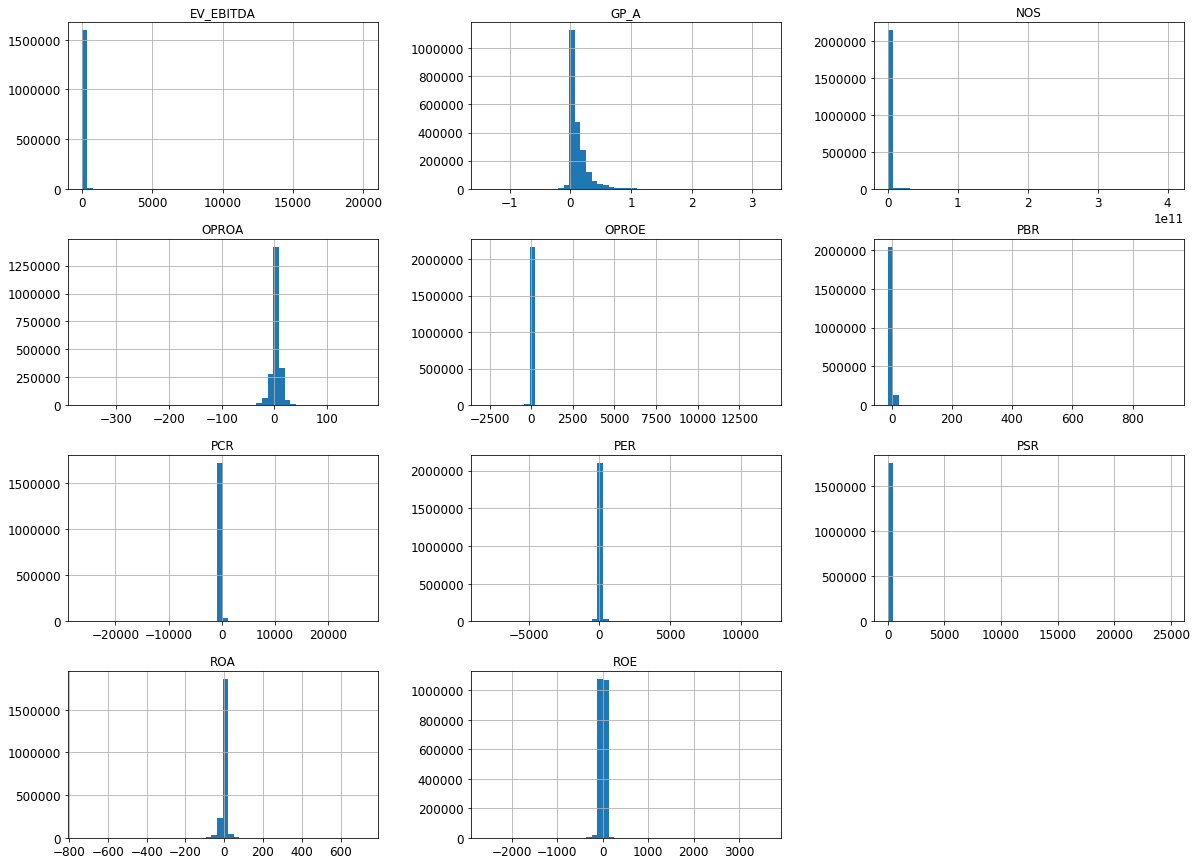

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
df1.hist(bins=50, figsize=(20,15))
plt.show()

In [73]:
temp_df = df1
for c in ['PER', 'PBR', 'PCR', 'PSR', 'ROE', 'ROA', 'OPROA', 'OPROE', 'EV_EBITDA']:
  temp_df = pd.merge(temp_df, df1[np.abs(df1[c]-df1[c].mean()) <= (3*df1[c].std())], how ='inner')
display(temp_df)

,itemname,date,PER,PBR,PCR,PSR,ROE,ROA,OPROA,OPROE,EV_EBITDA,GP_A,NOS
0,NICE평가정보,2017-09-20,17.082,3.111,13.223,1.399,19.60,13.85,17.924,25.241,8.87,0.0,483291400.0
1,NICE평가정보,2017-10-17,18.283,3.329,14.153,1.497,19.60,13.85,17.924,25.241,8.87,0.0,517291800.0
2,NICE평가정보,2017-01-04,14.614,2.661,11.312,1.197,19.60,13.85,17.924,25.241,8.87,0.0,413469150.0
3,NICE평가정보,2017-01-25,13.906,2.532,10.764,1.139,19.60,13.85,17.924,25.241,8.87,0.0,393433200.0
4,NICE평가정보,2017-04-25,17.382,3.165,13.455,1.423,19.60,13.85,17.924,25.241,8.87,0.0,491791500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1556147,휴니드테크놀러지스,2019-07-26,3.785,0.871,3.335,0.384,24.28,14.18,13.154,27.532,3.37,0.2,100223600.0
1556148,휴니드테크놀러지스,2019-08-30,3.630,0.835,3.199,0.368,24.28,14.18,13.154,27.532,3.37,0.2,96129960.0
1556149,휴니드테크놀러지스,2019-12-11,3.955,0.910,3.485,0.401,24.28,14.18,13.154,27.532,3.37,0.2,104740720.0
1556150,휴니드테크놀러지스,2019-11-13,3.673,0.845,3.236,0.372,24.28,14.18,13.154,27.532,3.37,0.2,97259240.0


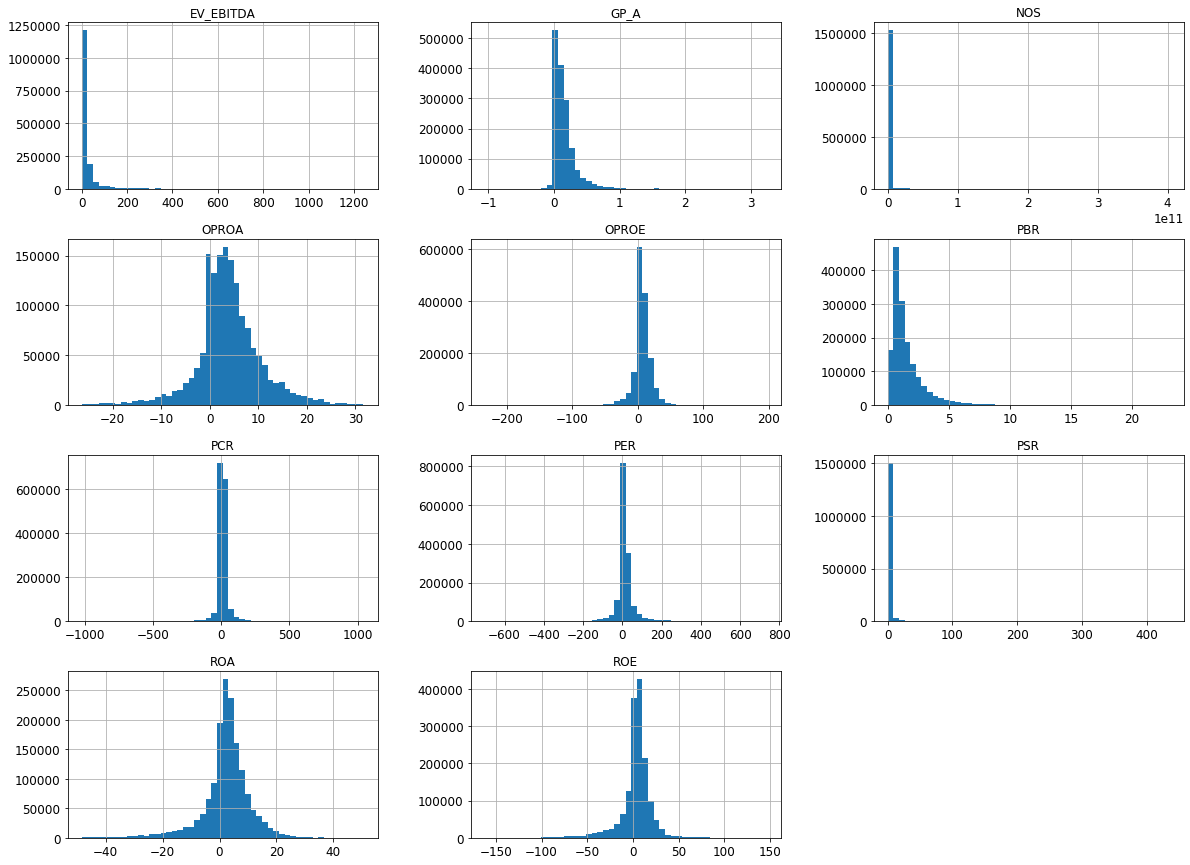

In [74]:
df1 = temp_df
df1.hist(bins=50, figsize=(20,15))
plt.show()

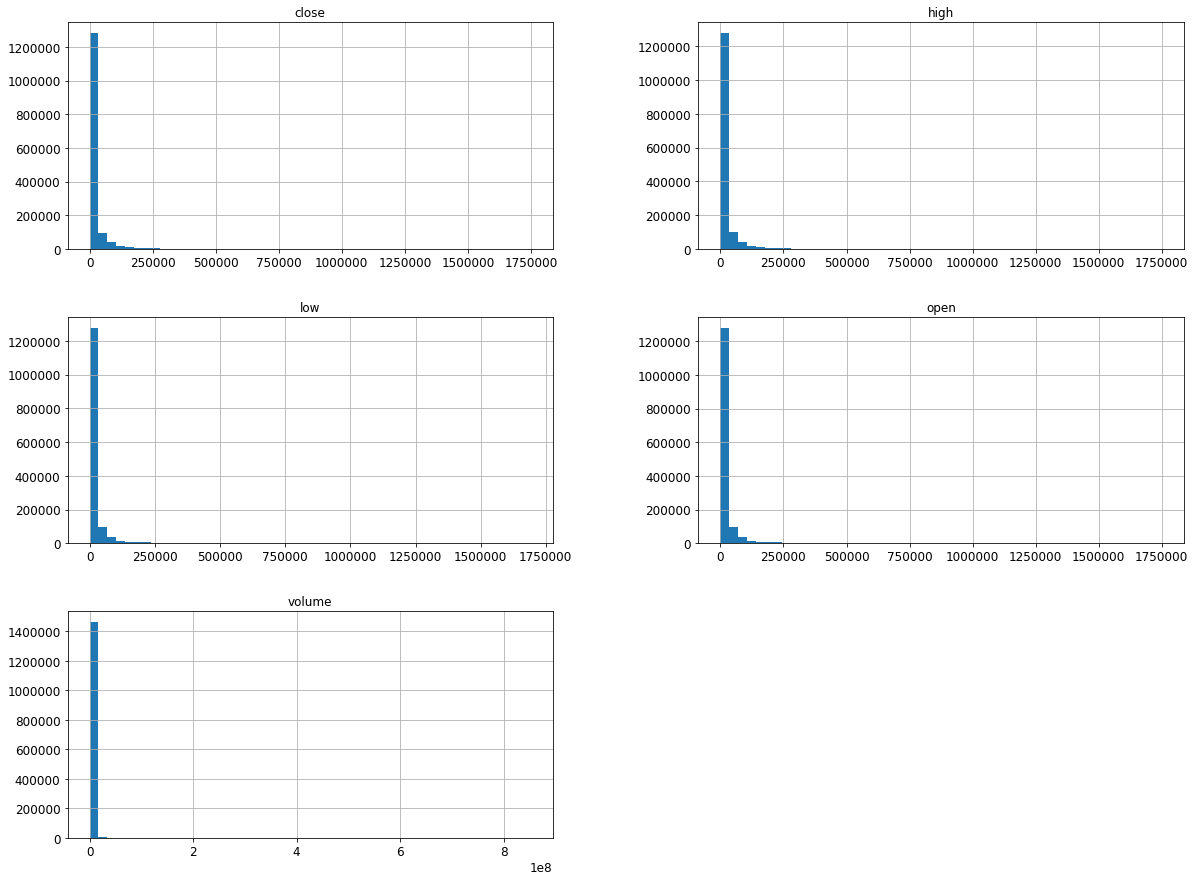

In [10]:
df2.hist(bins=50, figsize=(20,15))
plt.show()

In [75]:
df1 = df1.set_index('itemname')
df3 = df3.set_index('itemname')
df2 = df2.reset_index().sort_values(['itemname', 'date'])

In [76]:
nums = [5, 10, 20, 50, 120, 300]
for n in nums:
    df2[f'{n}dm'] = df2.groupby('itemname')['close'].rolling(n).mean().reset_index(0, drop=True)
    df2[f'{n}dmv'] = df2.groupby('itemname')['volume'].rolling(n).mean().reset_index(0, drop=True)

In [77]:
for i, x in enumerate(nums):
    for y in nums[i + 1:]:
        df2[f'{x}dm/{y}dm'] = df2[f'{x}dm'] / df2[f'{y}dm']
        df2[f'{x}dmv/{y}dmv'] = df2[f'{x}dmv'] / df2[f'{y}dmv']

df2 = df2.drop([f'{n}dm' for n in nums] + [f'{n}dmv' for n in nums], axis=1)
df2

,itemname,date,open,high,low,close,volume,5dm/10dm,5dmv/10dmv,5dm/20dm,...,20dm/120dm,20dmv/120dmv,20dm/300dm,20dmv/300dmv,50dm/120dm,50dmv/120dmv,50dm/300dm,50dmv/300dmv,120dm/300dm,120dmv/300dmv
1462,3S,2018-01-02,1860,1880,1830,1880,157321,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3435,3S,2018-01-03,1880,2045,1880,1995,637244,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5766,3S,2018-01-04,2050,2050,1990,2000,272501,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7469,3S,2018-01-05,2000,2190,1990,2180,716580,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7921,3S,2018-01-08,2185,2425,2160,2420,1576326,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1461506,힘스,2020-11-02,12750,13050,12600,12950,96113,0.980601,0.755227,0.960865,...,1.083956,1.125958,1.161420,1.661772,1.036364,1.040527,1.110427,1.535687,1.071464,1.475874
1463429,힘스,2020-11-03,13200,13300,13000,13000,140916,0.992729,0.874751,0.966468,...,1.081751,1.123616,1.160468,1.668855,1.034998,1.032589,1.110314,1.533657,1.072769,1.485254
1465202,힘스,2020-11-04,13250,13300,13000,13050,140881,1.000385,0.960805,0.971781,...,1.075844,0.912680,1.155533,1.359639,1.035432,1.009461,1.112128,1.503816,1.074071,1.489722
1466802,힘스,2020-11-05,13250,13250,13000,13200,138923,1.001156,0.884401,0.973946,...,1.070183,0.841419,1.150941,1.253974,1.035560,1.001382,1.113705,1.492367,1.075461,1.490308


In [14]:
df2.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,open,high,low,close,volume,5dm/10dm,5dmv/10dmv,5dm/20dm,5dmv/20dmv,5dm/50dm,...,20dm/120dm,20dmv/120dmv,20dm/300dm,20dmv/300dmv,50dm/120dm,50dmv/120dmv,50dm/300dm,50dmv/300dmv,120dm/300dm,120dmv/300dmv
count,1.47122e+06,1.47122e+06,1.47122e+06,1.47122e+06,1.47122e+06,1.45088e+06,1.42043e+06,1.4283e+06,1.40023e+06,1.36085e+06,...,1.20674e+06,1.1913e+06,817619,812514,1.20674e+06,1.1913e+06,817619,812514,817619,812514
mean,21430.2,21836.1,21027.8,21520.3,740223,0.999466,0.989304,0.999017,1.00275,0.997625,...,0.986566,1.07032,0.96901,1.32977,0.987549,1.02625,0.9637,1.2497,0.956231,1.12275
std,63162.5,64121.5,62220.7,63145.2,4.32768e+06,0.0342523,0.332887,0.0712551,0.598647,0.130798,...,0.168796,0.861221,0.293671,1.52449,0.113101,0.465725,0.242511,0.959624,0.156735,0.510941
min,0,0,0,107,0,0.170659,0,0.112206,0,0.0792295,...,0.0812008,0,0.0678915,0,0.112485,0,0.0929058,0,0.10459,0
25%,2700,2770,2635,2785,30099,0.98502,0.775126,0.966954,0.625023,0.935331,...,0.898278,0.525661,0.81806,0.479028,0.924499,0.702546,0.836069,0.602222,0.872999,0.753444
50%,6150,6300,6020,6210,108631,0.99949,0.966433,0.997889,0.874124,0.991567,...,0.974957,0.837993,0.931433,0.858476,0.981735,0.967297,0.936139,0.981189,0.946095,1.05926
75%,16150,16500,15750,16200,370475,1.01261,1.17611,1.02618,1.20339,1.04624,...,1.05093,1.30011,1.06028,1.55128,1.03759,1.29631,1.04741,1.60319,1.02243,1.46134
max,1.749e+06,1.749e+06,1.692e+06,1.749e+06,8.51967e+08,1.86857,2,3.37158,4,6.64668,...,4.70297,6,6.99224,15,2.22585,2.4,4.28942,6,2.16582,2.5


In [78]:
df2  = df2.set_index('itemname')

In [79]:
import arrow
date = arrow.get('2018-01-02')
df = pd.DataFrame()
while date < arrow.get('2020-08-06'):
    date_str = date.format('YYYY-MM-DD')
    date2 = df1[df1.date >= date.shift(months=3).format('YYYY-MM-DD')].date.min()
    temp = df1[df1.date == date_str]
    temp['ror'] = df2[df2.date == date2].close / df2[df2.date == date_str].close
    temp = temp.reset_index().set_index(['itemname', 'date'])
    temp = temp.join(df2[df2.date == date_str].reset_index().set_index(['itemname', 'date']).drop(['open', 'high', 'low', 'close', 'volume'], axis=1), how='inner')
    temp = temp.reset_index().set_index('itemname')
    temp[['market', 'sector', 'area']] = df3[['market', 'sector', 'area']]
    temp = temp.reset_index()
    df = df.append(temp)
    date = arrow.get(df1[df1.date >= date.shift(months=1).format('YYYY-MM-DD')].date.min())
df = df.reset_index()
df

C:\Users\gsr27\Anaconda3\envs\handson-ml2\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,index,itemname,date,PER,PBR,PCR,PSR,ROE,ROA,OPROA,...,20dmv/300dmv,50dm/120dm,50dmv/120dmv,50dm/300dm,50dmv/300dmv,120dm/300dm,120dmv/300dmv,market,sector,area
0,0,네패스,2018-01-02,31.225,1.512,4.668,0.725,5.05,1.30,6.264,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,kosdaq,반도체 제조업,충청북도
1,1,풍국주정,2018-01-02,12.633,1.504,8.825,1.664,12.56,9.25,6.941,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,kosdaq,알코올음료 제조업,대구광역시
2,2,코오롱머티리얼,2018-01-02,-2.496,1.106,-2.790,0.402,-36.36,-21.05,-17.562,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,kospi,화학섬유 제조업,경기도
3,3,이엔에프테크놀로지,2018-01-02,12.870,1.901,8.233,0.925,15.90,9.99,17.081,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,kosdaq,기타 화학제품 제조업,경기도
4,4,월덱스,2018-01-02,15.131,1.973,8.094,1.185,13.94,6.15,10.383,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,kosdaq,전자부품 제조업,경상북도
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52350,1716,보성파워텍,2020-07-22,93.750,1.045,26.786,1.884,1.19,0.79,-0.643,...,1.105677,1.028186,1.213918,0.916512,1.611789,0.891388,1.327758,kosdaq,"구조용 금속제품, 탱크 및 증기발생기 제조업",충청북도
52351,1717,에코바이오,2020-07-22,-24.326,1.570,75.965,13.282,-6.40,-5.78,-8.779,...,4.507912,1.339983,1.823477,1.384528,3.417989,1.033244,1.874435,kosdaq,사업시설 유지·관리 서비스업,서울특별시
52352,1718,한라,2020-07-22,2.200,0.515,3.594,0.200,24.50,4.08,6.915,...,0.528891,1.087846,0.723512,0.989975,0.899638,0.910032,1.243433,kospi,토목 건설업,서울특별시
52353,1719,유아이엘,2020-07-22,-4.578,0.539,38.148,0.664,-11.91,-9.14,-10.790,...,2.647683,0.976713,1.201169,0.875223,1.603772,0.896090,1.335176,kosdaq,전자부품 제조업,경기도


In [17]:
df.describe()

,index,PER,PBR,PCR,PSR,ROE,ROA,OPROA,OPROE,EV_EBITDA,...,20dm/120dm,20dmv/120dmv,20dm/300dm,20dmv/300dmv,50dm/120dm,50dmv/120dmv,50dm/300dm,50dmv/300dmv,120dm/300dm,120dmv/300dmv
count,52355.000000,52355.000000,52355.000000,52355.000000,52355.000000,52355.000000,52355.000000,52355.000000,52355.000000,52355.000000,...,42325.000000,42004.000000,27101.000000,26997.000000,42325.000000,42004.000000,27101.000000,26997.000000,27101.000000,26997.000000
mean,844.789399,12.647999,1.624114,10.391216,2.144541,2.236989,1.964025,3.553181,5.942865,29.459042,...,0.975030,1.076908,0.947571,1.284210,0.978957,1.032753,0.949048,1.207954,0.955614,1.075157
std,489.009029,71.672235,1.706907,75.503817,5.462122,19.682483,9.101664,6.996503,14.811309,70.717863,...,0.148135,0.852572,0.237215,1.469825,0.101110,0.463239,0.200206,0.929569,0.134925,0.492398
min,0.000000,-699.449000,0.002000,-1024.450000,0.000000,-162.140000,-48.460000,-26.377000,-183.333000,0.000000,...,0.084428,0.000000,0.109760,0.000000,0.112485,0.000000,0.109760,0.000000,0.109760,0.000000
25%,422.000000,-2.231000,0.654500,3.566000,0.409000,-1.590000,-0.830000,0.000000,0.000000,7.200000,...,0.891687,0.538573,0.814375,0.472889,0.919894,0.710119,0.836767,0.585033,0.878879,0.719572
50%,844.000000,9.126000,1.077000,8.362000,0.909000,4.620000,2.610000,3.214000,5.841000,11.550000,...,0.964778,0.851243,0.920222,0.835136,0.973756,0.974276,0.928844,0.939300,0.945473,0.999457
75%,1266.000000,21.477500,1.956000,17.452000,2.037000,10.550000,6.180000,6.777000,12.712000,22.940000,...,1.039861,1.303667,1.034236,1.491578,1.027827,1.299221,1.027448,1.534769,1.015623,1.383451
max,1769.000000,734.000000,22.474000,1037.500000,417.500000,145.940000,50.590000,31.667000,196.283000,1241.340000,...,2.765533,6.000000,3.712395,15.000000,1.832450,2.400000,3.538837,6.000000,2.017371,2.500000


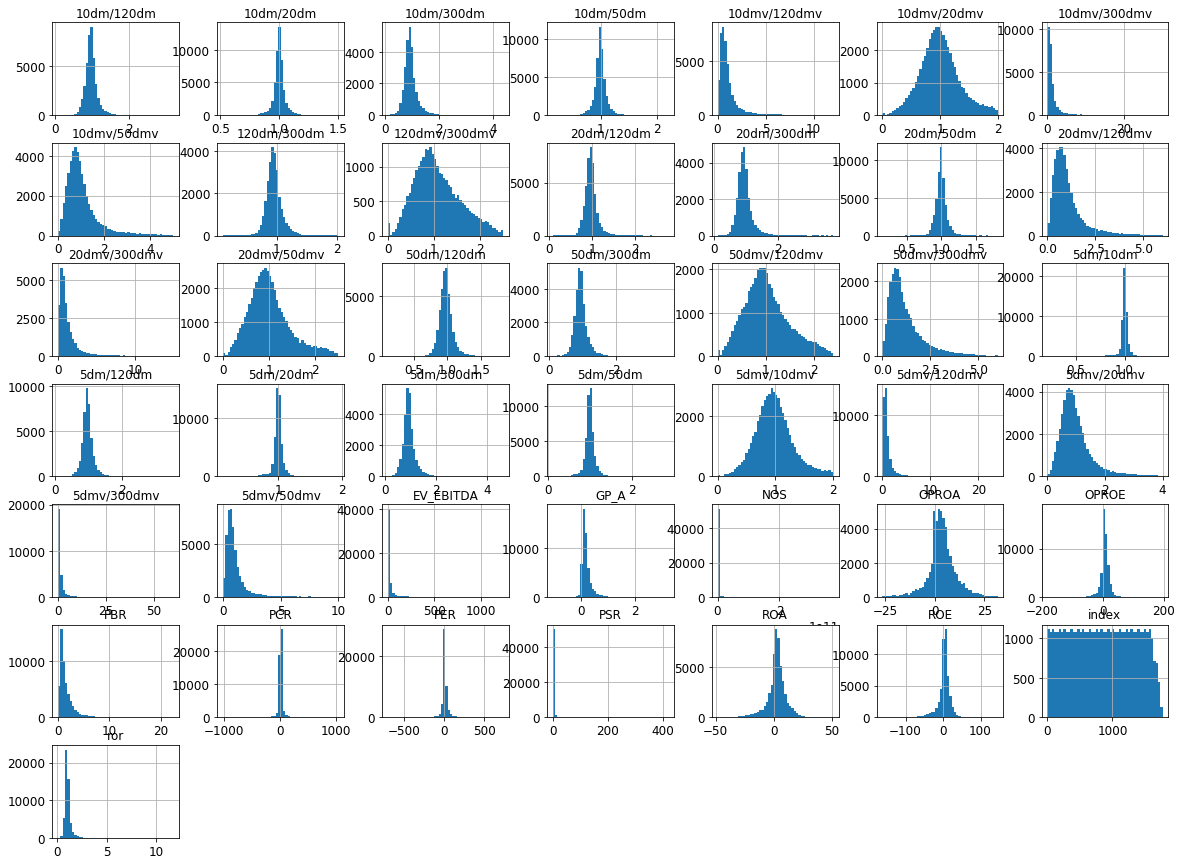

In [18]:
df.hist(bins=50, figsize=(20,15))
plt.show()

In [80]:
df.isnull().sum()

index                0
itemname             0
date                 0
PER                  0
PBR                  0
PCR                  0
PSR                  0
ROE                  0
ROA                  0
OPROA                0
OPROE                0
EV_EBITDA            0
GP_A                 0
NOS                  0
ror                 13
5dm/10dm          1640
5dmv/10dmv        2262
5dm/20dm          1671
5dmv/20dmv        2234
5dm/50dm          4992
5dmv/50dmv        5465
5dm/120dm        10030
5dmv/120dmv      10351
5dm/300dm        25254
5dmv/300dmv      25358
10dm/20dm         1671
10dmv/20dmv       2234
10dm/50dm         4992
10dmv/50dmv       5465
10dm/120dm       10030
10dmv/120dmv     10351
10dm/300dm       25254
10dmv/300dmv     25358
20dm/50dm         4992
20dmv/50dmv       5465
20dm/120dm       10030
20dmv/120dmv     10351
20dm/300dm       25254
20dmv/300dmv     25358
50dm/120dm       10030
50dmv/120dmv     10351
50dm/300dm       25254
50dmv/300dmv     25358
120dm/300dm

In [81]:
df = df.dropna()
df.isnull().sum()

index            0
itemname         0
date             0
PER              0
PBR              0
PCR              0
PSR              0
ROE              0
ROA              0
OPROA            0
OPROE            0
EV_EBITDA        0
GP_A             0
NOS              0
ror              0
5dm/10dm         0
5dmv/10dmv       0
5dm/20dm         0
5dmv/20dmv       0
5dm/50dm         0
5dmv/50dmv       0
5dm/120dm        0
5dmv/120dmv      0
5dm/300dm        0
5dmv/300dmv      0
10dm/20dm        0
10dmv/20dmv      0
10dm/50dm        0
10dmv/50dmv      0
10dm/120dm       0
10dmv/120dmv     0
10dm/300dm       0
10dmv/300dmv     0
20dm/50dm        0
20dmv/50dmv      0
20dm/120dm       0
20dmv/120dmv     0
20dm/300dm       0
20dmv/300dmv     0
50dm/120dm       0
50dmv/120dmv     0
50dm/300dm       0
50dmv/300dmv     0
120dm/300dm      0
120dmv/300dmv    0
market           0
sector           0
area             0
dtype: int64

In [21]:
df['PER_rank'] = df.PER.rank()
df['PBR_rank'] = df.PBR.rank()
df['PSR_rank'] = df.PSR.rank()
df['ROE_rank'] = df.ROE.rank(ascending=False)
df['ROA_rank'] = df.ROA.rank(ascending=False)
df['OPROE_rank'] = df.OPROE.rank(ascending=False)
df['OPROA_rank'] = df.OPROA.rank(ascending=False)
df['GP_A_rank'] = df.GP_A.rank(ascending=False)
df['final_rank'] = df['PBR_rank'] + df['ROE_rank'] + df['OPROE_rank']
df

C:\Users\gsr27\Anaconda3\envs\handson-ml2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\gsr27\Anaconda3\envs\handson-ml2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gsr27\Anaconda3\envs\handson-ml2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

,index,itemname,date,PER,PBR,PCR,PSR,ROE,ROA,OPROA,...,area,PER_rank,PBR_rank,PSR_rank,ROE_rank,ROA_rank,OPROE_rank,OPROA_rank,GP_A_rank,final_rank
24648,0,메타바이오메드,2019-04-11,-44.306,1.477,32.551,1.415,-3.54,-1.97,-0.401,...,충청북도,1400.0,17830.0,16631.0,20157.5,20350.5,20655.0,20580.0,8780.0,58642.5
24649,1,남해화학,2019-04-11,70.833,1.368,26.211,0.476,1.97,1.51,3.103,...,서울특별시,24953.0,17014.0,7629.0,15903.5,15033.5,13741.0,12035.0,9175.5,46658.5
24650,2,해태제과식품,2019-04-11,-69.079,0.945,9.868,0.421,-1.54,-0.55,0.877,...,충청남도,945.0,12601.5,6741.5,19163.0,18830.5,15440.5,16479.5,4014.5,47205.0
24651,3,희림,2019-04-11,34.714,1.145,11.489,0.399,3.78,1.38,2.751,...,서울특별시,23089.0,14998.0,6393.5,13608.5,15343.5,9854.0,12685.0,8240.0,38460.5
24653,5,우수AMS,2019-04-11,19.492,1.852,10.624,0.466,9.67,3.53,4.573,...,경상남도,20394.0,20235.0,7468.0,7213.0,10689.5,6326.0,9231.0,13381.5,33774.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52350,1716,보성파워텍,2020-07-22,93.750,1.045,26.786,1.884,1.19,0.79,-0.643,...,충청북도,25410.0,13939.5,18837.5,16858.5,16483.0,20786.0,20844.5,24508.0,51584.0
52351,1717,에코바이오,2020-07-22,-24.326,1.570,75.965,13.282,-6.40,-5.78,-8.779,...,서울특별시,2337.0,18519.5,25717.0,21394.0,22928.0,23928.0,25041.0,26194.5,63841.5
52352,1718,한라,2020-07-22,2.200,0.515,3.594,0.200,24.50,4.08,6.915,...,서울특별시,10216.0,5076.0,2528.5,1443.0,9561.5,387.0,5922.0,15593.0,6906.0
52353,1719,유아이엘,2020-07-22,-4.578,0.539,38.148,0.664,-11.91,-9.14,-10.790,...,경기도,5903.0,5552.0,10202.0,22838.0,24035.0,24589.0,25438.0,26219.5,52979.0


In [22]:
df.columns

Index(['index', 'itemname', 'date', 'PER', 'PBR', 'PCR', 'PSR', 'ROE', 'ROA',
       'OPROA', 'OPROE', 'EV_EBITDA', 'GP_A', 'NOS', 'ror', '5dm/10dm',
       '5dmv/10dmv', '5dm/20dm', '5dmv/20dmv', '5dm/50dm', '5dmv/50dmv',
       '5dm/120dm', '5dmv/120dmv', '5dm/300dm', '5dmv/300dmv', '10dm/20dm',
       '10dmv/20dmv', '10dm/50dm', '10dmv/50dmv', '10dm/120dm', '10dmv/120dmv',
       '10dm/300dm', '10dmv/300dmv', '20dm/50dm', '20dmv/50dmv', '20dm/120dm',
       '20dmv/120dmv', '20dm/300dm', '20dmv/300dmv', '50dm/120dm',
       '50dmv/120dmv', '50dm/300dm', '50dmv/300dmv', '120dm/300dm',
       '120dmv/300dmv', 'market', 'sector', 'area', 'PER_rank', 'PBR_rank',
       'PSR_rank', 'ROE_rank', 'ROA_rank', 'OPROE_rank', 'OPROA_rank',
       'GP_A_rank', 'final_rank'],
      dtype='object')

In [23]:
df['quantile'] = pd.qcut(df['final_rank'], 30, labels=False)
df

C:\Users\gsr27\Anaconda3\envs\handson-ml2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,index,itemname,date,PER,PBR,PCR,PSR,ROE,ROA,OPROA,...,PER_rank,PBR_rank,PSR_rank,ROE_rank,ROA_rank,OPROE_rank,OPROA_rank,GP_A_rank,final_rank,quantile
24648,0,메타바이오메드,2019-04-11,-44.306,1.477,32.551,1.415,-3.54,-1.97,-0.401,...,1400.0,17830.0,16631.0,20157.5,20350.5,20655.0,20580.0,8780.0,58642.5,25
24649,1,남해화학,2019-04-11,70.833,1.368,26.211,0.476,1.97,1.51,3.103,...,24953.0,17014.0,7629.0,15903.5,15033.5,13741.0,12035.0,9175.5,46658.5,20
24650,2,해태제과식품,2019-04-11,-69.079,0.945,9.868,0.421,-1.54,-0.55,0.877,...,945.0,12601.5,6741.5,19163.0,18830.5,15440.5,16479.5,4014.5,47205.0,20
24651,3,희림,2019-04-11,34.714,1.145,11.489,0.399,3.78,1.38,2.751,...,23089.0,14998.0,6393.5,13608.5,15343.5,9854.0,12685.0,8240.0,38460.5,15
24653,5,우수AMS,2019-04-11,19.492,1.852,10.624,0.466,9.67,3.53,4.573,...,20394.0,20235.0,7468.0,7213.0,10689.5,6326.0,9231.0,13381.5,33774.0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52350,1716,보성파워텍,2020-07-22,93.750,1.045,26.786,1.884,1.19,0.79,-0.643,...,25410.0,13939.5,18837.5,16858.5,16483.0,20786.0,20844.5,24508.0,51584.0,23
52351,1717,에코바이오,2020-07-22,-24.326,1.570,75.965,13.282,-6.40,-5.78,-8.779,...,2337.0,18519.5,25717.0,21394.0,22928.0,23928.0,25041.0,26194.5,63841.5,27
52352,1718,한라,2020-07-22,2.200,0.515,3.594,0.200,24.50,4.08,6.915,...,10216.0,5076.0,2528.5,1443.0,9561.5,387.0,5922.0,15593.0,6906.0,0
52353,1719,유아이엘,2020-07-22,-4.578,0.539,38.148,0.664,-11.91,-9.14,-10.790,...,5903.0,5552.0,10202.0,22838.0,24035.0,24589.0,25438.0,26219.5,52979.0,23


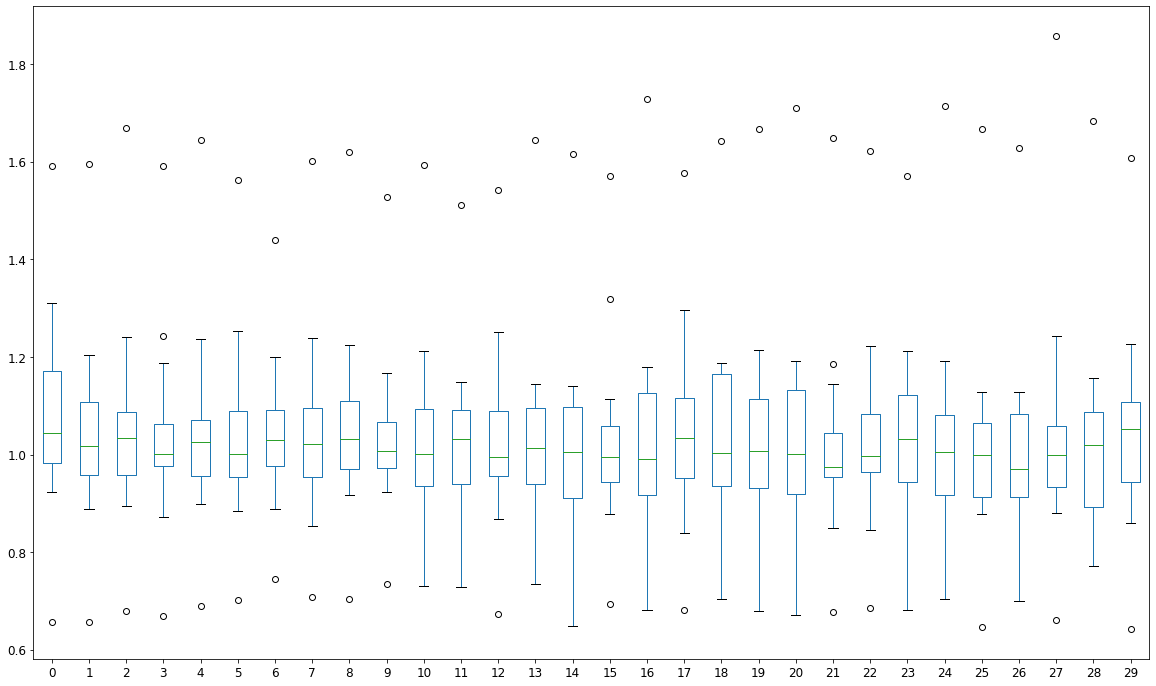

In [24]:
pd.DataFrame(df.groupby(['date', 'quantile'])['ror'].mean()).reset_index().pivot(index='date', columns='quantile', values='ror').plot.box(figsize=(20,12))

In [82]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

In [83]:
test_set.head()

,index,itemname,date,PER,PBR,PCR,PSR,ROE,ROA,OPROA,...,20dmv/300dmv,50dm/120dm,50dmv/120dmv,50dm/300dm,50dmv/300dmv,120dm/300dm,120dmv/300dmv,market,sector,area
34853,1587,금호전기,2019-09-16,-0.557,0.304,-2.428,0.267,-74.74,-28.20,-6.511,...,2.729692,0.760865,1.213330,0.480047,2.602334,0.630923,2.144787,kospi,전구 및 조명장치 제조업,서울특별시
46751,1421,SH에너지화학,2020-04-20,-12.389,1.023,-49.556,3.964,-8.18,-6.81,-9.555,...,1.590616,0.873560,0.545497,0.799890,0.833482,0.915667,1.527930,kospi,기초 화학물질 제조업,전라북도
29087,993,정산애강,2019-06-13,16.241,1.703,13.381,1.878,11.08,9.36,12.034,...,1.871043,0.998710,0.748034,0.918461,0.920233,0.919647,1.230203,kosdaq,플라스틱제품 제조업,충청북도
45129,1507,SFA반도체,2020-03-20,0.000,2.009,8.740,1.014,0.02,-0.09,8.106,...,1.350624,1.279625,1.235899,1.777000,1.504944,1.388688,1.217691,kosdaq,반도체 제조업,충청남도
46692,1362,화성밸브,2020-04-20,0.000,0.888,14.797,0.943,4.33,3.21,0.000,...,1.881633,0.872559,1.836667,0.667520,1.531213,0.765014,0.833691,kosdaq,일반 목적용 기계 제조업,대구광역시


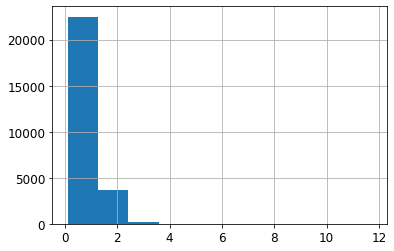

In [84]:
df["ror"].hist()

In [85]:
df["ror_cat"] = pd.cut(df["ror"], bins=[0., 0.6, 0.9, 1.1, 1.5, np.inf], labels=[1, 2, 3, 4, 5])

C:\Users\gsr27\Anaconda3\envs\handson-ml2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [86]:
df["ror_cat"].value_counts()

3    10315
2     8194
4     5304
5     1911
1      710
Name: ror_cat, dtype: int64

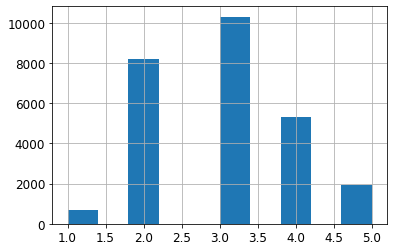

In [87]:
df["ror_cat"].hist()

In [100]:
df = df.reset_index(drop=True)
df

,itemname,date,PER,PBR,PCR,PSR,ROE,ROA,OPROA,OPROE,...,50dm/120dm,50dmv/120dmv,50dm/300dm,50dmv/300dmv,120dm/300dm,120dmv/300dmv,market,sector,area,ror_cat
0,메타바이오메드,2019-04-11,-44.306,1.477,32.551,1.415,-3.54,-1.97,-0.401,-0.786,...,1.029352,0.997288,0.840408,0.189932,0.816444,0.190449,kosdaq,의료용품 및 기타 의약 관련제품 제조업,충청북도,2
1,남해화학,2019-04-11,70.833,1.368,26.211,0.476,1.97,1.51,3.103,4.003,...,1.030474,0.985224,0.914021,0.498653,0.886991,0.506132,kospi,"비료, 농약 및 살균, 살충제 제조업",서울특별시,2
2,해태제과식품,2019-04-11,-69.079,0.945,9.868,0.421,-1.54,-0.55,0.877,2.550,...,1.067560,1.015988,0.867552,1.306348,0.812649,1.285791,kospi,기타 식품 제조업,충청남도,2
3,희림,2019-04-11,34.714,1.145,11.489,0.399,3.78,1.38,2.751,7.859,...,1.055670,0.866108,1.038729,0.691182,0.983952,0.798031,kosdaq,"건축기술, 엔지니어링 및 관련 기술 서비스업",서울특별시,3
4,우수AMS,2019-04-11,19.492,1.852,10.624,0.466,9.67,3.53,4.573,12.398,...,1.127561,1.112363,1.016708,0.894947,0.901688,0.804545,kosdaq,자동차 신품 부품 제조업,경상남도,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26429,보성파워텍,2020-07-22,93.750,1.045,26.786,1.884,1.19,0.79,-0.643,-0.972,...,1.028186,1.213918,0.916512,1.611789,0.891388,1.327758,kosdaq,"구조용 금속제품, 탱크 및 증기발생기 제조업",충청북도,3
26430,에코바이오,2020-07-22,-24.326,1.570,75.965,13.282,-6.40,-5.78,-8.779,-10.079,...,1.339983,1.823477,1.384528,3.417989,1.033244,1.874435,kosdaq,사업시설 유지·관리 서비스업,서울특별시,3
26431,한라,2020-07-22,2.200,0.515,3.594,0.200,24.50,4.08,6.915,40.389,...,1.087846,0.723512,0.989975,0.899638,0.910032,1.243433,kospi,토목 건설업,서울특별시,3
26432,유아이엘,2020-07-22,-4.578,0.539,38.148,0.664,-11.91,-9.14,-10.790,-14.118,...,0.976713,1.201169,0.875223,1.603772,0.896090,1.335176,kosdaq,전자부품 제조업,경기도,3


In [101]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["ror_cat"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [102]:
strat_test_set["ror_cat"].value_counts() / len(strat_test_set)

3    0.390202
2    0.310006
4    0.200681
5    0.072253
1    0.026858
Name: ror_cat, dtype: float64

In [103]:
df["ror_cat"].value_counts() / len(df)

3    0.390217
2    0.309980
4    0.200651
5    0.072293
1    0.026859
Name: ror_cat, dtype: float64

In [104]:
def income_cat_proportions(data):
    return data["ror_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(df),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [105]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.026859,0.026858,0.027047,0.700416,-0.003783
2,0.309980,0.310006,0.308303,-0.540741,0.008421
3,0.390217,0.390202,0.394931,1.207999,-0.003783
4,0.200651,0.200681,0.195574,-2.530082,0.015070
5,0.072293,0.072253,0.074144,2.560223,-0.056110


In [106]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("ror_cat", axis=1, inplace=True)

# 데이터 이해를 위한 탐색과 시각화

In [107]:
tdf = strat_train_set.copy()
tdf

,itemname,date,PER,PBR,PCR,PSR,ROE,ROA,OPROA,OPROE,...,20dmv/300dmv,50dm/120dm,50dmv/120dmv,50dm/300dm,50dmv/300dmv,120dm/300dm,120dmv/300dmv,market,sector,area
12381,에스디생명공학,2019-11-18,-429.167,1.062,13.919,0.735,-0.29,-0.68,0.000,0.000,...,2.619867,0.915888,1.977835,0.683358,2.055263,0.746115,1.039148,kosdaq,기타 화학제품 제조업,서울특별시
12447,서연,2019-11-18,-0.684,0.167,0.700,0.037,-23.89,-6.37,0.211,0.549,...,0.303023,0.924847,0.198334,0.878344,0.411066,0.949718,2.072592,kospi,기타 금융업,경기도
887,신세계건설,2019-04-11,2.795,0.615,2.342,0.111,24.25,6.00,2.879,11.145,...,0.688394,1.077651,1.369161,0.950965,0.999759,0.882443,0.730198,kospi,건물 건설업,서울특별시
21445,아세아,2020-05-20,30.787,0.224,5.666,0.500,0.73,0.54,1.931,3.791,...,2.661702,0.862486,1.700433,0.746413,2.496336,0.865420,1.468059,kospi,회사 본부 및 경영 컨설팅 서비스업,서울특별시
15292,로체시스템즈,2020-01-20,49.655,1.312,34.083,1.104,2.76,1.65,1.000,1.835,...,1.028459,1.036517,0.817424,1.130472,0.704191,1.090645,0.861476,kosdaq,특수 목적용 기계 제조업,경기도
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14825,테스나,2019-12-18,18.734,3.668,10.226,4.660,21.87,15.62,16.756,22.973,...,0.996632,0.947736,0.971520,1.124643,1.155492,1.186663,1.189365,kosdaq,"그외 기타 전문, 과학 및 기술 서비스업",경기도
4475,모나리자,2019-06-13,-72.400,2.051,69.615,1.171,-2.72,-2.29,-3.226,-3.876,...,0.129337,0.965800,0.199232,0.974769,0.271008,1.009287,1.360260,kospi,기타 종이 및 판지 제품 제조업,서울특별시
25640,대주산업,2020-07-22,15.000,1.014,22.727,1.249,6.83,4.09,5.006,8.397,...,6.708884,1.038044,1.840366,0.939515,3.084342,0.905083,1.675939,kosdaq,동물용 사료 및 조제식품 제조업,서울특별시
24966,다믈멀티미디어,2020-07-22,0.000,1.527,42.786,2.285,3.61,2.22,0.000,0.000,...,1.428388,0.979034,1.014572,0.861614,0.812709,0.880065,0.801037,kosdaq,반도체 제조업,서울특별시


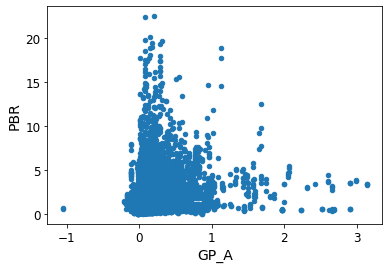

In [108]:
tdf.plot(kind="scatter", x="GP_A", y="PBR")

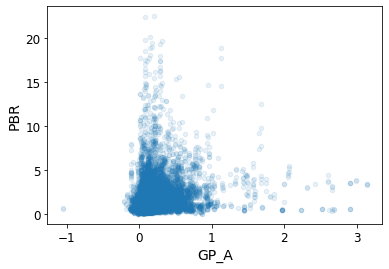

In [109]:
tdf.plot(kind="scatter", x="GP_A", y="PBR", alpha=0.1)

`sharex=False` 매개변수는 x-축의 값과 범례를 표시하지 못하는 버그를 수정합니다. 이는 임시 방편입니다(https://github.com/pandas-dev/pandas/issues/10611 참조). 수정 사항을 알려준 Wilmer Arellano에게 감사합니다.

In [110]:
corr_matrix = df.corr()

In [111]:
corr_matrix["ror"].sort_values(ascending=False)

ror              1.000000
10dmv/20dmv      0.067896
10dmv/50dmv      0.051402
50dmv/120dmv     0.049006
10dmv/120dmv     0.047168
50dmv/300dmv     0.046865
120dmv/300dmv    0.045295
20dmv/120dmv     0.041338
20dmv/300dmv     0.035847
10dmv/300dmv     0.034130
20dmv/50dmv      0.033603
5dmv/50dmv       0.033374
5dmv/120dmv      0.033050
5dmv/20dmv       0.030623
PSR              0.024963
5dmv/300dmv      0.021530
GP_A             0.017341
OPROA            0.014156
OPROE            0.013816
EV_EBITDA        0.010002
ROA              0.009555
120dm/300dm      0.004934
ROE              0.003202
PCR              0.003043
NOS             -0.003885
PER             -0.016115
5dmv/10dmv      -0.016729
50dm/300dm      -0.023853
PBR             -0.026357
50dm/120dm      -0.061340
20dm/300dm      -0.065097
10dm/300dm      -0.093323
20dm/120dm      -0.115081
5dm/300dm       -0.126961
20dm/50dm       -0.147233
10dm/120dm      -0.150941
10dm/50dm       -0.186933
10dm/20dm       -0.187030
5dm/120dm   

In [112]:
피어슨의 상관 계수(위키백과):
![Pearson correlation coefficient](https://upload.wikimedia.org/wikipedia/commons/d/d4/Correlation_examples2.svg)

SyntaxError: invalid syntax (<ipython-input-112-2010d0096813>, line 1)

[0, 4, 0, 6]

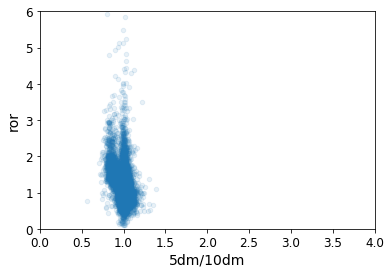

In [113]:
df.plot(kind="scatter", x="5dm/10dm", y="ror", alpha=0.1)
plt.axis([0, 4, 0, 6])

# 머신러닝 알고리즘을 위한 데이터 준비

In [114]:
tdf = strat_train_set.drop("ror", axis=1) # 훈련 세트를 위해 레이블 삭제
tdf_labels = strat_train_set["ror"].copy()

In [115]:
sample_incomplete_rows = tdf[tdf.isnull().any(axis=1)].head()
sample_incomplete_rows

,itemname,date,PER,PBR,PCR,PSR,ROE,ROA,OPROA,OPROE,...,20dmv/300dmv,50dm/120dm,50dmv/120dmv,50dm/300dm,50dmv/300dmv,120dm/300dm,120dmv/300dmv,market,sector,area


In [ ]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])    # 옵션 1

In [ ]:
sample_incomplete_rows.drop("total_bedrooms", axis=1)       # 옵션 2

In [ ]:
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # 옵션 3

In [ ]:
sample_incomplete_rows

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

중간값이 수치형 특성에서만 계산될 수 있기 때문에 텍스트 특성을 삭제합니다:

In [ ]:
housing_num = housing.drop("ocean_proximity", axis=1)
# 다른 방법: housing_num = housing.select_dtypes(include=[np.number])

In [ ]:
imputer.fit(housing_num)

In [ ]:
imputer.statistics_

각 특성의 중간 값이 수동으로 계산한 것과 같은지 확인해 보세요:

In [ ]:
housing_num.median().values

훈련 세트를 변환합니다:

In [ ]:
X = imputer.transform(housing_num)

In [ ]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [ ]:
housing_tr.loc[sample_incomplete_rows.index.values]

In [ ]:
imputer.strategy

In [ ]:
housing_tr.head()

이제 범주형 입력 특성인 `ocean_proximity`을 전처리합니다:

In [116]:
tdf_cat = tdf[["market"]]
tdf_cat.head(10)

,market
12381,kosdaq
12447,kospi
887,kospi
21445,kospi
15292,kosdaq
13986,kosdaq
21477,kosdaq
15342,kospi
16034,kosdaq
18154,kospi


In [117]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
tdf_cat = ordinal_encoder.fit_transform(tdf_cat)
tdf_cat[:10]

array([[0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.]])

In [118]:
ordinal_encoder.categories_

[array(['kosdaq', 'kospi'], dtype=object)]

In [119]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
tdf_cat_1hot = cat_encoder.fit_transform(tdf_cat)
tdf_cat_1hot

<21147x2 sparse matrix of type '<class 'numpy.float64'>'
	with 21147 stored elements in Compressed Sparse Row format>

`OneHotEncoder`는 기본적으로 희소 행렬을 반환합니다. 필요하면 `toarray()` 메서드를 사용해 밀집 배열로 변환할 수 있습니다:

In [120]:
tdf_cat_1hot.toarray()

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]])

또는 `OneHotEncoder`를 만들 때 `sparse=False`로 지정할 수 있습니다:

In [121]:
cat_encoder = OneHotEncoder(sparse=False)
tdf_cat_1hot = cat_encoder.fit_transform(tdf_cat)
tdf_cat_1hot

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]])

In [122]:
cat_encoder.categories_

[array([0., 1.])]

추가 특성을 위해 사용자 정의 변환기를 만들어보죠:

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

# 열 인덱스
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # *args 또는 **kargs 없음
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # 아무것도 하지 않습니다
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.to_numpy())

In [ ]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

수치형 특성을 전처리하기 위해 파이프라인을 만듭니다:

In [123]:
tdf = tdf.set_index(['itemname', 'date'])
tdf_num = tdf.drop(["market", "sector", "area"], axis=1)

In [124]:
tdf_num.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 21147 entries, (에스디생명공학, 2019-11-18 00:00:00) to (사조동아원, 2019-05-13 00:00:00)
Data columns (total 41 columns):
PER              21147 non-null float64
PBR              21147 non-null float64
PCR              21147 non-null float64
PSR              21147 non-null float64
ROE              21147 non-null float64
ROA              21147 non-null float64
OPROA            21147 non-null float64
OPROE            21147 non-null float64
EV_EBITDA        21147 non-null float64
GP_A             21147 non-null float64
NOS              21147 non-null float64
5dm/10dm         21147 non-null float64
5dmv/10dmv       21147 non-null float64
5dm/20dm         21147 non-null float64
5dmv/20dmv       21147 non-null float64
5dm/50dm         21147 non-null float64
5dmv/50dmv       21147 non-null float64
5dm/120dm        21147 non-null float64
5dmv/120dmv      21147 non-null float64
5dm/300dm        21147 non-null float64
5dmv/300dmv      21147 non-null float64

In [125]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])

tdf_num_tr = num_pipeline.fit_transform(tdf_num)

In [126]:
tdf_num_tr

array([[-6.45213808, -0.26156523,  0.01693711, ...,  0.89915195,
        -1.58457819, -0.089667  ],
       [-0.13984628, -0.82548324, -0.14633282, ..., -0.87578052,
        -0.05912651,  2.03845064],
       [-0.08859462, -0.5432092 , -0.12605222, ..., -0.24027898,
        -0.56317324, -0.72587156],
       ...,
       [ 0.09120603, -0.29180888,  0.12572609, ...,  2.01005675,
        -0.39354901,  1.22164442],
       [-0.12976978,  0.03142011,  0.37347793, ..., -0.44220189,
        -0.58098388, -0.57999769],
       [ 0.05534902, -0.28424797, -0.07106487, ...,  2.8115378 ,
         0.12524168,  2.34292649]])

In [127]:
from sklearn.compose import ColumnTransformer

num_attribs = list(tdf_num)
cat_attribs = ["market", "sector", "area"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

tdf_prepared = full_pipeline.fit_transform(tdf)

In [128]:
tdf_prepared

<21147x208 sparse matrix of type '<class 'numpy.float64'>'
	with 930468 stored elements in Compressed Sparse Row format>

In [129]:
tdf_prepared.shape

(21147, 208)

다음은 (판다스 `DataFrame` 열의 일부를 선택하기 위해) `DataFrameSelector` 변환기와 `FeatureUnion`를 사용한 예전 방식입니다:

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

# 수치형 열과 범주형 열을 선택하기 위한 클래스
class OldDataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

하나의 큰 파이프라인에 이들을 모두 결합하여 수치형과 범주형 특성을 전처리합니다:

In [ ]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

old_num_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

old_cat_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

In [ ]:
from sklearn.pipeline import FeatureUnion

old_full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", old_num_pipeline),
        ("cat_pipeline", old_cat_pipeline),
    ])

In [ ]:
old_housing_prepared = old_full_pipeline.fit_transform(housing)
old_housing_prepared

`ColumnTransformer`의 결과와 동일합니다:

In [ ]:
np.allclose(housing_prepared, old_housing_prepared)

# 모델 선택과 훈련

In [130]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(tdf_prepared, tdf_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [131]:
# 훈련 샘플 몇 개를 사용해 전체 파이프라인을 적용해 보겠습니다
some_data = tdf.iloc[:5]
some_labels = tdf_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("예측:", lin_reg.predict(some_data_prepared))

예측: [1.1190042  1.0465833  0.91370019 1.06594203 0.95522551]


실제 값과 비교합니다:

In [132]:
print("레이블:", list(some_labels))

레이블: [1.029126213592233, 1.4257575757575758, 0.9966777408637874, 0.9160401002506265, 0.8732638888888888]


In [133]:
some_data_prepared

<5x208 sparse matrix of type '<class 'numpy.float64'>'
	with 220 stored elements in Compressed Sparse Row format>

In [134]:
from sklearn.metrics import mean_squared_error

tdf_predictions = lin_reg.predict(tdf_prepared)
lin_mse = mean_squared_error(tdf_labels, tdf_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.3260529292324532

In [135]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(tdf_labels, tdf_predictions)
lin_mae

0.19257609862199748

In [136]:
from sklearn.neural_network import MLPRegressor

mlp_reg = MLPRegressor(random_state=42)
mlp_reg.fit(tdf_prepared, tdf_labels)
tdf_predictions = mlp_reg.predict(tdf_prepared)
lin_mse = mean_squared_error(tdf_labels, tdf_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.1909097785797569

In [137]:
lin_mae = mean_absolute_error(tdf_labels, tdf_predictions)
lin_mae

0.12999435932956704

In [138]:
tdf

,,PER,PBR,PCR,PSR,ROE,ROA,OPROA,OPROE,EV_EBITDA,GP_A,...,20dmv/300dmv,50dm/120dm,50dmv/120dmv,50dm/300dm,50dmv/300dmv,120dm/300dm,120dmv/300dmv,market,sector,area
itemname,date,,,,,,,,,,,,,,,,,,,,,
에스디생명공학,2019-11-18,-429.167,1.062,13.919,0.735,-0.29,-0.68,0.000,0.000,16.34,0.404,...,2.619867,0.915888,1.977835,0.683358,2.055263,0.746115,1.039148,kosdaq,기타 화학제품 제조업,서울특별시
서연,2019-11-18,-0.684,0.167,0.700,0.037,-23.89,-6.37,0.211,0.549,9.27,0.082,...,0.303023,0.924847,0.198334,0.878344,0.411066,0.949718,2.072592,kospi,기타 금융업,경기도
신세계건설,2019-04-11,2.795,0.615,2.342,0.111,24.25,6.00,2.879,11.145,3.33,0.107,...,0.688394,1.077651,1.369161,0.950965,0.999759,0.882443,0.730198,kospi,건물 건설업,서울특별시
아세아,2020-05-20,30.787,0.224,5.666,0.500,0.73,0.54,1.931,3.791,5.49,0.077,...,2.661702,0.862486,1.700433,0.746413,2.496336,0.865420,1.468059,kospi,회사 본부 및 경영 컨설팅 서비스업,서울특별시
로체시스템즈,2020-01-20,49.655,1.312,34.083,1.104,2.76,1.65,1.000,1.835,17.49,0.127,...,1.028459,1.036517,0.817424,1.130472,0.704191,1.090645,0.861476,kosdaq,특수 목적용 기계 제조업,경기도
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
테스나,2019-12-18,18.734,3.668,10.226,4.660,21.87,15.62,16.756,22.973,4.12,0.189,...,0.996632,0.947736,0.971520,1.124643,1.155492,1.186663,1.189365,kosdaq,"그외 기타 전문, 과학 및 기술 서비스업",경기도
모나리자,2019-06-13,-72.400,2.051,69.615,1.171,-2.72,-2.29,-3.226,-3.876,102.96,0.261,...,0.129337,0.965800,0.199232,0.974769,0.271008,1.009287,1.360260,kospi,기타 종이 및 판지 제품 제조업,서울특별시
대주산업,2020-07-22,15.000,1.014,22.727,1.249,6.83,4.09,5.006,8.397,13.19,0.159,...,6.708884,1.038044,1.840366,0.939515,3.084342,0.905083,1.675939,kosdaq,동물용 사료 및 조제식품 제조업,서울특별시


In [143]:
df1.date.max()

Timestamp('2020-11-06 00:00:00')

In [159]:
date = '2020-11-06'
temp = df2[df2.date == date].drop(['open', 'high', 'low', 'close', 'volume'], axis=1)
pdf = pd.merge(df1[df1.date == date], temp, left_index=True, right_index=True, how='inner')
pdf[['market', 'sector', 'area']] = df3[['market', 'sector', 'area']]
pdf = pdf.rename(columns={'date_x': 'date'})
pdf = pdf.reset_index().set_index(['itemname', 'date'])
pdf = pdf.dropna()
pdf

,,PER,PBR,PCR,PSR,ROE,ROA,OPROA,OPROE,EV_EBITDA,GP_A,...,20dmv/300dmv,50dm/120dm,50dmv/120dmv,50dm/300dm,50dmv/300dmv,120dm/300dm,120dmv/300dmv,market,sector,area
itemname,date,,,,,,,,,,,,,,,,,,,,,
GS글로벌,2020-11-06,4.628,0.388,4.943,0.094,8.510,2.550,4.861,14.663,7.15,0.122,...,0.701141,0.991405,0.650278,0.885689,0.726116,0.893368,1.116624,kospi,상품 종합 도매업,서울특별시
하이트진로,2020-11-06,17.689,2.168,16.986,2.211,13.410,3.510,5.032,20.390,12.98,0.241,...,0.593476,0.928788,0.746766,1.116466,0.846999,1.202067,1.134223,kospi,알코올음료 제조업,서울특별시
대원화성,2020-11-06,-11.758,0.775,45.606,1.150,-6.550,-3.890,-2.329,-4.010,7.69,0.087,...,0.284768,0.966626,0.193859,1.100970,0.327749,1.138983,1.690653,kospi,플라스틱제품 제조업,서울특별시
에스원,2020-11-06,24.970,2.144,19.210,2.907,0.096,0.070,0.101,0.138,9.92,0.327,...,0.784201,0.979580,1.021326,0.959627,0.937250,0.979631,0.917679,kospi,"경비, 경호 및 탐정업",서울특별시
글로본,2020-11-06,0.000,4.601,-12.984,9.280,-38.250,-23.090,0.000,0.000,51.08,0.078,...,1.467418,1.078021,1.452279,1.052275,2.637789,0.976117,1.816311,kosdaq,상품 종합 도매업,서울특별시
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
삼성바이오로직스,2020-11-06,229.068,11.571,324.969,99.846,0.051,0.037,0.037,0.051,127.54,0.070,...,0.695288,0.990612,0.618878,1.324007,0.604118,1.336555,0.976150,kospi,기초 의약물질 및 생물학적 제제 제조업,인천광역시
이노인스트루먼트,2020-11-06,5.396,0.978,13.721,3.207,23.230,11.830,6.233,9.328,19.27,0.205,...,0.286957,1.017941,1.221650,0.812310,1.074279,0.797993,0.879367,kosdaq,통신 및 방송 장비 제조업,인천광역시
코리아오토글라스,2020-11-06,0.000,0.806,5.079,0.638,9.360,6.220,0.000,0.000,3.95,0.210,...,1.847041,1.016412,1.295045,0.971288,1.621515,0.955604,1.252092,kospi,유리 및 유리제품 제조업,세종특별자치시


In [160]:
pdf_prepared = full_pipeline.fit_transform(pdf)
pdf_prepared

<1665x208 sparse matrix of type '<class 'numpy.float64'>'
	with 73260 stored elements in Compressed Sparse Row format>

In [161]:
pdf_predictions = mlp_reg.predict(pdf_prepared)
pdf_predictions

array([0.79507989, 1.53665178, 1.09617605, ..., 0.65136239, 1.65839775,
       0.90476748])

In [164]:
pdf['pred_ror'] = pdf_predictions
pdf['pred_ror_rank'] = pdf['pred_ror'].rank(ascending=False)
pdf = pdf.sort_values('pred_ror_rank')
pdf.head(30)

,,PER,PBR,PCR,PSR,ROE,ROA,OPROA,OPROE,EV_EBITDA,GP_A,...,50dmv/120dmv,50dm/300dm,50dmv/300dmv,120dm/300dm,120dmv/300dmv,market,sector,area,pred_ror,pred_ror_rank
itemname,date,,,,,,,,,,,,,,,,,,,,,
호전실업,2020-11-06,-2.513,0.565,-10.452,0.559,-23.030,-8.410,1.096,3.169,8.03,0.134,...,1.184980,0.710055,1.753952,0.779201,1.480153,kospi,봉제의복 제조업,서울특별시,3.062725,1.0
엔브이에이치코리아,2020-11-06,5.440,0.819,26.497,0.250,15.230,3.140,4.481,20.779,7.30,0.106,...,1.209677,1.529841,1.459914,1.146934,1.206862,kosdaq,자동차 신품 부품 제조업,울산광역시,2.567468,2.0
비엠티,2020-11-06,10.321,0.989,11.765,1.542,9.720,5.430,8.098,15.094,8.22,0.191,...,0.987776,1.157658,1.233211,1.131633,1.248471,kosdaq,일반 목적용 기계 제조업,경상남도,2.462919,3.0
명문제약,2020-11-06,-4.368,2.056,-13.122,2.630,-45.840,-14.380,-16.407,-45.427,32.48,0.134,...,0.826254,1.235872,1.434666,1.218066,1.736350,kospi,의약품 제조업,경기도,2.420117,4.0
코오롱인더,2020-11-06,25.951,0.513,3.633,0.567,0.020,0.010,0.022,0.051,8.79,0.203,...,1.068537,0.955666,1.202356,0.914639,1.125236,kospi,화학섬유 제조업,서울특별시,2.413394,5.0
SK디앤디,2020-11-06,7.178,1.976,13.626,3.007,28.570,7.530,9.837,33.095,10.48,0.145,...,1.416726,1.433642,3.019117,1.158943,2.131053,kospi,부동산 임대 및 공급업,경기도,2.412425,6.0
이상네트웍스,2020-11-06,1.678,0.547,6.941,3.436,34.010,22.140,3.224,4.680,7.79,0.069,...,0.334976,0.909302,0.410839,0.922690,1.226474,kosdaq,상품 중개업,서울특별시,2.293413,7.0
지엔씨에너지,2020-11-06,8.071,1.132,29.118,1.141,14.830,8.090,2.881,4.400,7.50,0.084,...,1.041400,1.296941,2.178101,1.190004,2.091512,kosdaq,"전동기, 발전기 및 전기 변환 · 공급 · 제어 장치 제조업",서울특별시,2.250138,8.0
엘티씨,2020-11-06,22.335,0.995,14.982,2.051,4.660,2.490,3.741,6.919,10.53,0.143,...,0.532138,1.116949,0.821793,1.023309,1.544323,kosdaq,기초 화학물질 제조업,경기도,2.240149,9.0


In [585]:
from xgboost import XGBRegressor

xgb_reg = XGBRegressor(random_state=42)
xgb_reg.fit(tdf_prepared, tdf_labels)
tdf_predictions = xgb_reg.predict(tdf_prepared)
lin_mse = mean_squared_error(tdf_labels, tdf_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

C:\Users\gsr27\Anaconda3\envs\handson-ml2\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[06:05:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.2673817973658515

In [586]:
lin_mae = mean_absolute_error(tdf_labels, tdf_predictions)
lin_mae

0.16213459134493635

In [587]:
from lightgbm import LGBMRegressor

lgb_reg = LGBMRegressor(random_state=42)
lgb_reg.fit(tdf_prepared, tdf_labels)
tdf_predictions = lgb_reg.predict(tdf_prepared)
lin_mse = mean_squared_error(tdf_labels, tdf_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.22916130464994786

In [588]:
lin_mae = mean_absolute_error(tdf_labels, tdf_predictions)
lin_mae

0.14226609995453313

In [416]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(tdf_prepared, tdf_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [417]:
housing_predictions = tree_reg.predict(tdf_prepared)
tree_mse = mean_squared_error(tdf_labels, tdf_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.32855789559673143

# 모델 세부 튜닝

In [117]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, tdf_prepared, tdf_labels,
                         scoring="neg_mean_squared_error", cv=3)
tree_rmse_scores = np.sqrt(-scores)

In [118]:
def display_scores(scores):
    print("점수:", scores)
    print("평균:", scores.mean())
    print("표준 편차:", scores.std())

display_scores(tree_rmse_scores)

점수: [0.44496571 0.421406   0.42907964]
평균: 0.4318171165869935
표준 편차: 0.009811056135197498


In [119]:
lin_scores = cross_val_score(lin_reg, tdf_prepared, tdf_labels,
                             scoring="neg_mean_squared_error", cv=3)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

점수: [0.34505726 0.32650883 0.31370743]
평균: 0.3284245082759539
표준 편차: 0.012869998146267991


**노트**: 사이킷런 0.22 버전에서 `n_estimators`의 기본값이 100으로 바뀌기 때문에 향후를 위해 `n_estimators=100`로 지정합니다(책에는 등장하지 않습니다).

In [120]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(tdf_prepared, tdf_labels)

KeyboardInterrupt: 

In [ ]:
tdf_predictions = forest_reg.predict(tdf_prepared)
forest_mse = mean_squared_error(tdf_labels, tdf_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18603.515021376355

In [ ]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, tdf_prepared, tdf_labels,
                                scoring="neg_mean_squared_error", cv=3)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

점수: [49519.80364233 47461.9115823  50029.02762854 52325.28068953
 49308.39426421 53446.37892622 48634.8036574  47585.73832311
 53490.10699751 50021.5852922 ]
평균: 50182.303100336096
표준 편차: 2097.0810550985693


In [ ]:
scores = cross_val_score(lin_reg, tdf_prepared, tdf_labels, scoring="neg_mean_squared_error", cv=3)
pd.Series(np.sqrt(-scores)).describe()

count       10.000000
mean     69052.461363
std       2879.437224
min      64969.630564
25%      67136.363758
50%      68156.372635
75%      70982.369487
max      74739.570526
dtype: float64

In [ ]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(tdf_prepared, tdf_labels)
tdf_predictions = svm_reg.predict(tdf_prepared)
svm_mse = mean_squared_error(tdf_labels, tdf_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # 12(=3×4)개의 하이퍼파라미터 조합을 시도합니다.
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # bootstrap은 False로 하고 6(=2×3)개의 조합을 시도합니다.
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# 다섯 개의 폴드로 훈련하면 총 (12+6)*5=90번의 훈련이 일어납니다.
grid_search = GridSearchCV(forest_reg, param_grid, cv=3,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(tdf_prepared, tdf_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

최상의 파라미터 조합은 다음과 같습니다:

In [ ]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [ ]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)

그리드서치에서 테스트한 하이퍼파라미터 조합의 점수를 확인합니다:

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63669.11631261028 {'max_features': 2, 'n_estimators': 3}
55627.099719926795 {'max_features': 2, 'n_estimators': 10}
53384.57275149205 {'max_features': 2, 'n_estimators': 30}
60965.950449450494 {'max_features': 4, 'n_estimators': 3}
52741.04704299915 {'max_features': 4, 'n_estimators': 10}
50377.40461678399 {'max_features': 4, 'n_estimators': 30}
58663.93866579625 {'max_features': 6, 'n_estimators': 3}
52006.19873526564 {'max_features': 6, 'n_estimators': 10}
50146.51167415009 {'max_features': 6, 'n_estimators': 30}
57869.25276169646 {'max_features': 8, 'n_estimators': 3}
51711.127883959234 {'max_features': 8, 'n_estimators': 10}
49682.273345071546 {'max_features': 8, 'n_estimators': 30}
62895.06951262424 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54658.176157539405 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59470.40652318466 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52724.9822587892 {'bootstrap': False, 'max_features': 3, 'n_estimators'

In [ ]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.050877,0.001108,0.002517,0.000015,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-3.837622e+09,-4.147108e+09,...,-4.053756e+09,1.519591e+08,18,-1.064113e+09,-1.105142e+09,-1.116550e+09,-1.112342e+09,-1.129650e+09,-1.105559e+09,2.220402e+07
1,0.164428,0.001815,0.007119,0.000019,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-3.047771e+09,-3.254861e+09,...,-3.094374e+09,1.327062e+08,11,-5.927175e+08,-5.870952e+08,-5.776964e+08,-5.716332e+08,-5.802501e+08,-5.818785e+08,7.345821e+06
2,0.495403,0.004303,0.019859,0.000051,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.689185e+09,-3.021086e+09,...,-2.849913e+09,1.626875e+08,9,-4.381089e+08,-4.391272e+08,-4.371702e+08,-4.376955e+08,-4.452654e+08,-4.394734e+08,2.966320e+06
3,0.084140,0.001059,0.002532,0.000008,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.730181e+09,-3.786886e+09,...,-3.716847e+09,1.631510e+08,16,-9.865163e+08,-1.012565e+09,-9.169425e+08,-1.037400e+09,-9.707739e+08,-9.848396e+08,4.084607e+07
4,0.275067,0.001553,0.007142,0.000011,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.666283e+09,-2.784511e+09,...,-2.781618e+09,1.268607e+08,8,-5.097115e+08,-5.162820e+08,-4.962893e+08,-5.436192e+08,-5.160297e+08,-5.163863e+08,1.542862e+07
5,0.819323,0.002004,0.019863,0.000012,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.387153e+09,-2.588448e+09,...,-2.537883e+09,1.214614e+08,3,-3.838835e+08,-3.880268e+08,-3.790867e+08,-4.040957e+08,-3.845520e+08,-3.879289e+08,8.571233e+06
6,0.113894,0.003145,0.002529,0.000011,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.119657e+09,-3.586319e+09,...,-3.441458e+09,1.893056e+08,14,-9.245343e+08,-8.886939e+08,-9.353135e+08,-9.009801e+08,-8.624664e+08,-9.023976e+08,2.591445e+07
7,0.379435,0.002942,0.007157,0.000031,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.549663e+09,-2.782039e+09,...,-2.704645e+09,1.471569e+08,6,-4.980344e+08,-5.045869e+08,-4.994664e+08,-4.990325e+08,-5.055542e+08,-5.013349e+08,3.100456e+06
8,1.150662,0.005214,0.019885,0.000035,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.370010e+09,-2.583638e+09,...,-2.514673e+09,1.285080e+08,2,-3.838538e+08,-3.804711e+08,-3.805218e+08,-3.856095e+08,-3.901917e+08,-3.841296e+08,3.617057e+06
9,0.145883,0.000841,0.002519,0.000015,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-3.353504e+09,-3.348552e+09,...,-3.348850e+09,1.241939e+08,13,-9.228123e+08,-8.553031e+08,-8.603321e+08,-8.881964e+08,-9.151287e+08,-8.883545e+08,2.750227e+07


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=3, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(tdf_prepared, tdf_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff4c8035550>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff4c80358d0>},
                   random_state=42, scoring='neg_mean_squared_error')

In [ ]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49150.70756927707 {'max_features': 7, 'n_estimators': 180}
51389.889203389284 {'max_features': 5, 'n_estimators': 15}
50796.155224308866 {'max_features': 3, 'n_estimators': 72}
50835.13360315349 {'max_features': 5, 'n_estimators': 21}
49280.9449827171 {'max_features': 7, 'n_estimators': 122}
50774.90662363929 {'max_features': 3, 'n_estimators': 75}
50682.78888164288 {'max_features': 3, 'n_estimators': 88}
49608.99608105296 {'max_features': 5, 'n_estimators': 100}
50473.61930350219 {'max_features': 3, 'n_estimators': 150}
64429.84143294435 {'max_features': 5, 'n_estimators': 2}


In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03])

In [ ]:
#cat_encoder = cat_pipeline.named_steps["cat_encoder"] # 예전 방식
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.36615898061813423, 'median_income'),
 (0.16478099356159054, 'INLAND'),
 (0.10879295677551575, 'pop_per_hhold'),
 (0.07334423551601243, 'longitude'),
 (0.06290907048262032, 'latitude'),
 (0.056419179181954014, 'rooms_per_hhold'),
 (0.053351077347675815, 'bedrooms_per_room'),
 (0.04114379847872964, 'housing_median_age'),
 (0.014874280890402769, 'population'),
 (0.014672685420543239, 'total_rooms'),
 (0.014257599323407808, 'households'),
 (0.014106483453584104, 'total_bedrooms'),
 (0.010311488326303788, '<1H OCEAN'),
 (0.0028564746373201584, 'NEAR OCEAN'),
 (0.0019604155994780706, 'NEAR BAY'),
 (6.0280386727366e-05, 'ISLAND')]

In [ ]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("ror", axis=1)
y_test = strat_test_set["ror"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [ ]:
final_rmse

47730.22690385927

테스트 RMSE에 대한 95% 신뢰 구간을 계산할 수 있습니다:

In [ ]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([45685.10470776, 49691.25001878])

다음과 같이 수동으로 계산할 수도 있습니다:

In [ ]:
m = len(squared_errors)
mean = squared_errors.mean()
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(45685.10470776014, 49691.25001877871)

또는 t-점수 대신 z-점수를 사용할 수도 있습니다:

In [ ]:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(45685.717918136594, 49690.68623889426)

# 추가 내용

## 전처리와 예측을 포함한 전체 파이프라인

In [ ]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

array([210644.60459286, 317768.80697211, 210956.43331178,  59218.98886849,
       189747.55849879])

## joblib를 사용한 모델 저장

In [ ]:
my_model = full_pipeline_with_predictor

In [ ]:
import joblib
joblib.dump(my_model, "my_model.pkl") # DIFF
#...
my_model_loaded = joblib.load("my_model.pkl") # DIFF

## `RandomizedSearchCV`를 위한 Scipy 분포 함수

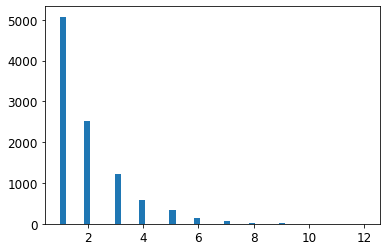

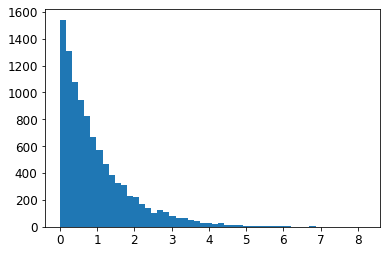

In [ ]:
from scipy.stats import geom, expon
geom_distrib=geom(0.5).rvs(10000, random_state=42)
expon_distrib=expon(scale=1).rvs(10000, random_state=42)
plt.hist(geom_distrib, bins=50)
plt.show()
plt.hist(expon_distrib, bins=50)
plt.show()

In [ ]:
temp = df1[df1.date == '2020-11-06']
temp['OPROA_rank'] = temp.OPROA.rank(ascending=False)
temp['GP_A_rank'] = temp.GP_A.rank(ascending=False)
temp['OPROA+GP_A_rank'] = temp['OPROA_rank'] + temp['GP_A_rank']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [ ]:
temp.sort_values('OPROA+GP_A_rank')[:26].sort_values('GP_A_rank')[:6]

,itemname,date,PER,PBR,PCR,PSR,ROE,ROA,OPROA,OPROE,EV_EBITDA,GP_A,NOS,OPROA_rank,GP_A_rank,OPROA+GP_A_rank
1650788,고려신용정보,2020-11-06,8.840,3.392,11.786,1.215,40.68,17.29,18.939,44.248,5.54,2.424,7.736300e+07,56.0,2.0,58.0
73590,SCI평가정보,2020-11-06,11.551,6.969,25.330,6.093,66.76,45.64,56.825,73.646,9.58,1.805,1.771450e+08,8.0,5.0,13.0
1236656,랩지노믹스,2020-11-06,3.139,5.112,10.889,5.517,209.72,159.49,150.361,192.593,11.00,1.740,3.377110e+08,1.0,6.0,7.0
55022,미스터블루,2020-11-06,10.459,4.531,18.142,3.951,48.55,35.77,41.808,56.381,11.14,1.684,2.536568e+08,16.0,7.0,23.0
196284,씨젠,2020-11-06,13.810,22.571,42.180,20.238,212.31,137.58,135.173,218.205,24.67,1.652,7.216973e+09,2.0,8.0,10.0
550921,뉴트리,2020-11-06,12.107,2.962,19.414,2.192,26.71,17.86,22.505,33.333,9.55,1.439,1.955232e+08,41.0,11.0,52.0


# 연습문제 해답

## 1.

질문: 서포트 벡터 머신 회귀(`sklearn.svm.SVR`)를 `kernel=“linear”`(하이퍼파라미터 `C`를 바꿔가며)나 `kernel=“rbf”`(하이퍼파라미터 `C`와 `gamma`를 바꿔가며) 등의 다양한 하이퍼파라미터 설정으로 시도해보세요. 지금은 이 하이퍼파라미터가 무엇을 의미하는지 너무 신경 쓰지 마세요. 최상의 `SVR` 모델은 무엇인가요?

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] C=10.0, kernel=linear ...........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................ C=10.0, kernel=linear, total=   6.8s
[CV] C=10.0, kernel=linear ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.8s remaining:    0.0s


[CV] ............................ C=10.0, kernel=linear, total=   6.8s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   6.8s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   6.8s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   6.8s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=30.0, kernel=linear, total=   6.7s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=30.0, kernel=linear, total=   6.7s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=30.0, kernel=linear, total=   6.9s
[CV] C=30.0, kernel=linear ...........................................
[CV] .

[CV] ..................... C=1.0, gamma=0.3, kernel=rbf, total=  11.0s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=1.0, kernel=rbf, total=  10.5s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=1.0, kernel=rbf, total=  10.5s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=1.0, kernel=rbf, total=  10.5s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=1.0, kernel=rbf, total=  10.5s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=1.0, kernel=rbf, total=  10.5s
[CV] C=1.0, gamma=3.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=3.0, kernel=rbf, total=  11.0s
[CV] C=1.0, gamma=3.0, kernel=rbf ....................................
[CV] .

[CV] .................... C=10.0, gamma=0.3, kernel=rbf, total=  11.0s
[CV] C=10.0, gamma=0.3, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=0.3, kernel=rbf, total=  11.0s
[CV] C=10.0, gamma=0.3, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=0.3, kernel=rbf, total=  11.0s
[CV] C=10.0, gamma=1.0, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=1.0, kernel=rbf, total=  10.5s
[CV] C=10.0, gamma=1.0, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=1.0, kernel=rbf, total=  10.5s
[CV] C=10.0, gamma=1.0, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=1.0, kernel=rbf, total=  10.5s
[CV] C=10.0, gamma=1.0, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=1.0, kernel=rbf, total=  10.5s
[CV] C=10.0, gamma=1.0, kernel=rbf ...................................
[CV] .

[CV] ................... C=100.0, gamma=0.3, kernel=rbf, total=  10.8s
[CV] C=100.0, gamma=0.3, kernel=rbf ..................................
[CV] ................... C=100.0, gamma=0.3, kernel=rbf, total=  10.8s
[CV] C=100.0, gamma=0.3, kernel=rbf ..................................
[CV] ................... C=100.0, gamma=0.3, kernel=rbf, total=  10.8s
[CV] C=100.0, gamma=0.3, kernel=rbf ..................................
[CV] ................... C=100.0, gamma=0.3, kernel=rbf, total=  10.8s
[CV] C=100.0, gamma=0.3, kernel=rbf ..................................
[CV] ................... C=100.0, gamma=0.3, kernel=rbf, total=  10.9s
[CV] C=100.0, gamma=1.0, kernel=rbf ..................................
[CV] ................... C=100.0, gamma=1.0, kernel=rbf, total=  10.5s
[CV] C=100.0, gamma=1.0, kernel=rbf ..................................
[CV] ................... C=100.0, gamma=1.0, kernel=rbf, total=  10.5s
[CV] C=100.0, gamma=1.0, kernel=rbf ..................................
[CV] .

[CV] .................. C=1000.0, gamma=0.1, kernel=rbf, total=  10.7s
[CV] C=1000.0, gamma=0.1, kernel=rbf .................................
[CV] .................. C=1000.0, gamma=0.1, kernel=rbf, total=  10.6s
[CV] C=1000.0, gamma=0.3, kernel=rbf .................................
[CV] .................. C=1000.0, gamma=1.0, kernel=rbf, total=  10.4s
[CV] C=1000.0, gamma=1.0, kernel=rbf .................................
[CV] .................. C=1000.0, gamma=1.0, kernel=rbf, total=  10.4s
[CV] C=1000.0, gamma=1.0, kernel=rbf .................................
[CV] .................. C=1000.0, gamma=1.0, kernel=rbf, total=  10.4s
[CV] C=1000.0, gamma=3.0, kernel=rbf .................................
[CV] .................. C=1000.0, gamma=3.0, kernel=rbf, total=  11.0s
[CV] C=1000.0, gamma=3.0, kernel=rbf .................................
[CV] .................. C=1000.0, gamma=3.0, kernel=rbf, total=  11.0s
[CV] C=1000.0, gamma=3.0, kernel=rbf .................................
[CV] .

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 44.3min finished


GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0,
                                10000.0, 30000.0],
                          'kernel': ['linear']},
                         {'C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0],
                          'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                          'kernel': ['rbf']}],
             scoring='neg_mean_squared_error', verbose=2)

최상 모델의 (5-폴드 교차 검증으로 평가한) 점수는 다음과 같습니다:

In [ ]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

70363.84006944533

`RandomForestRegressor`보다 훨씬 좋지 않네요. 최상의 하이퍼파라미터를 확인해 보겠습니다:

In [ ]:
grid_search.best_params_

{'C': 30000.0, 'kernel': 'linear'}

선형 커널이 RBF 커널보다 성능이 나은 것 같습니다. `C`는 테스트한 것 중에 최대값이 선택되었습니다. 따라서 (작은 값들은 지우고) 더 큰 값의 `C`로 그리드서치를 다시 실행해 보아야 합니다. 아마도 더 큰 값의 `C`에서 성능이 높아질 것입니다.

## 2.

질문: `GridSearchCV`를 `RandomizedSearchCV`로 바꿔보세요.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# expon(), reciprocal()와 그외 다른 확률 분포 함수에 대해서는
# https://docs.scipy.org/doc/scipy/reference/stats.html를 참고하세요.

# 노트: kernel 매개변수가 "linear"일 때는 gamma가 무시됩니다.
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   6.8s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.8s remaining:    0.0s


[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   6.9s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   6.9s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   6.9s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   6.9s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=  13.0s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=  13.4s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=  13.2s
[CV] C=26290.2

[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total= 1.1min
[CV] C=171377.39570378003, gamma=0.628789100540856, kernel=linear ....
[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total=  51.6s
[CV] C=171377.39570378003, gamma=0.628789100540856, kernel=linear ....
[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total= 1.1min
[CV] C=171377.39570378003, gamma=0.628789100540856, kernel=linear ....
[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total=  56.8s
[CV] C=171377.39570378003, gamma=0.628789100540856, kernel=linear ....
[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total=  44.5s
[CV] C=5385.293820172355, gamma=0.18696125197741642, kernel=linear ...
[CV]  C=5385.293820172355, gamma=0.18696125197741642, kernel=linear, total=   8.3s
[CV] C=5385.293820172355, gamma=0.18696125197741642, kernel=linear ...
[CV]  C=5385.293820172355, gamma=0.18696125197741642, kernel=linear, total=   8.5

[CV]  C=761.4316758498783, gamma=2.6126336514161914, kernel=linear, total=   6.9s
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total=  36.9s
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total=  35.8s
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total=  56.0s
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total=  37.9s
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total=  30.7s
[CV] C=2423.0759984939164, gamma=3.248614270240346, kernel=linear ....
[CV]  C=2423.0759984939164, gamma=3.248614270240346, kernel=linear, total=   

[CV]  C=251.14073886281363, gamma=0.8238105204914145, kernel=linear, total=   6.6s
[CV] C=251.14073886281363, gamma=0.8238105204914145, kernel=linear ...
[CV]  C=251.14073886281363, gamma=0.8238105204914145, kernel=linear, total=   6.8s
[CV] C=251.14073886281363, gamma=0.8238105204914145, kernel=linear ...
[CV]  C=251.14073886281363, gamma=0.8238105204914145, kernel=linear, total=   6.8s
[CV] C=251.14073886281363, gamma=0.8238105204914145, kernel=linear ...
[CV]  C=251.14073886281363, gamma=0.8238105204914145, kernel=linear, total=   6.8s
[CV] C=251.14073886281363, gamma=0.8238105204914145, kernel=linear ...
[CV]  C=251.14073886281363, gamma=0.8238105204914145, kernel=linear, total=   6.8s
[CV] C=60.17373642891687, gamma=1.2491263443165994, kernel=linear ....
[CV]  C=60.17373642891687, gamma=1.2491263443165994, kernel=linear, total=   6.8s
[CV] C=60.17373642891687, gamma=1.2491263443165994, kernel=linear ....
[CV]  C=60.17373642891687, gamma=1.2491263443165994, kernel=linear, total=   

[CV]  C=6287.039489427172, gamma=0.3504567255332862, kernel=linear, total=   8.4s
[CV] C=61217.04421344494, gamma=1.6279689407405564, kernel=rbf .......
[CV]  C=61217.04421344494, gamma=1.6279689407405564, kernel=rbf, total=  37.5s
[CV] C=61217.04421344494, gamma=1.6279689407405564, kernel=rbf .......
[CV]  C=61217.04421344494, gamma=1.6279689407405564, kernel=rbf, total=  43.1s
[CV] C=61217.04421344494, gamma=1.6279689407405564, kernel=rbf .......
[CV]  C=61217.04421344494, gamma=1.6279689407405564, kernel=rbf, total=  40.6s
[CV] C=61217.04421344494, gamma=1.6279689407405564, kernel=rbf .......
[CV]  C=61217.04421344494, gamma=1.6279689407405564, kernel=rbf, total=  41.5s
[CV] C=61217.04421344494, gamma=1.6279689407405564, kernel=rbf .......
[CV]  C=61217.04421344494, gamma=1.6279689407405564, kernel=rbf, total=  38.6s
[CV] C=926.9787684096649, gamma=2.147979593060577, kernel=rbf ........
[CV]  C=926.9787684096649, gamma=2.147979593060577, kernel=rbf, total=  10.6s
[CV] C=926.97876840

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 68.0min finished


RandomizedSearchCV(cv=5, estimator=SVR(), n_iter=50,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff4cb149b50>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff4ddacce10>,
                                        'kernel': ['linear', 'rbf']},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

최상 모델의 (5-폴드 교차 검증으로 평가한) 점수는 다음과 같습니다:

In [ ]:
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

54767.960710084146

이제 `RandomForestRegressor`의 성능에 훨씬 가까워졌습니다(하지만 아직 차이가 납니다). 최상의 하이퍼파라미터를 확인해 보겠습니다:

In [ ]:
rnd_search.best_params_

{'C': 157055.10989448498, 'gamma': 0.26497040005002437, 'kernel': 'rbf'}

이번에는 RBF 커널에 대해 최적의 하이퍼파라미터 조합을 찾았습니다. 보통 랜덤서치가 같은 시간안에 그리드서치보다 더 좋은 하이퍼파라미터를 찾습니다.

여기서 사용된 `scale=1.0`인 지수 분포를 살펴보겠습니다. 일부 샘플은 1.0보다 아주 크거나 작습니다. 하지만 로그 분포를 보면 대부분의 값이 exp(-2)와 exp(+2), 즉 0.1과 7.4 사이에 집중되어 있음을 알 수 있습니다.

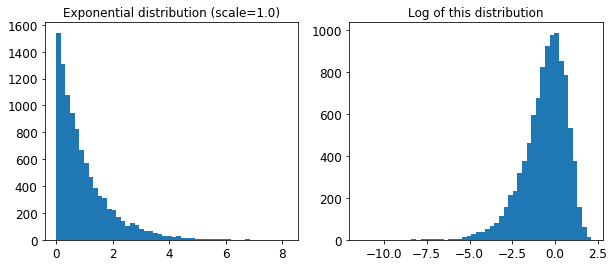

In [ ]:
expon_distrib = expon(scale=1.)
samples = expon_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Exponential distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

`C`에 사용된 분포는 매우 다릅니다. 주어진 범위안에서 균등 분포로 샘플링됩니다. 그래서 오른쪽 로그 분포가 거의 일정하게 나타납니다. 이런 분포는 원하는 스케일이 정확이 무엇인지 모를 때 사용하면 좋습니다:

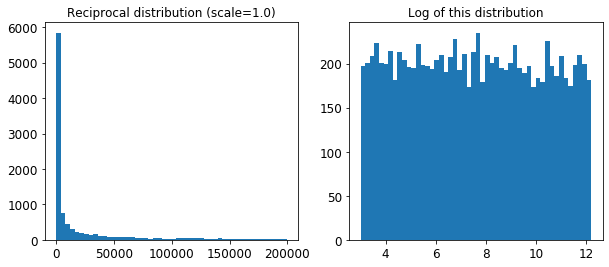

In [ ]:
reciprocal_distrib = reciprocal(20, 200000)
samples = reciprocal_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Reciprocal distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

`reciprocal()` 함수는 하이퍼파라미터의 스케일에 대해 전혀 감을 잡을 수 없을 때 사용합니다(오른쪽 그래프에서 볼 수 있듯이 주어진 범위안에서 모든 값이 균등합니다). 반면 지수 분포는 하이퍼파라미터의 스케일을 (어느정도) 알고 있을 때 사용하는 것이 좋습니다.

## 3.

질문: 가장 중요한 특성을 선택하는 변환기를 준비 파이프라인에 추가해보세요.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

노트: 이 특성 선택 클래스는 이미 어떤 식으로든 특성 중요도를 계산했다고 가정합니다(가령 `RandomForestRegressor`을 사용하여). `TopFeatureSelector`의 `fit()` 메서드에서 직접 계산할 수도 있지만 (캐싱을 사용하지 않을 경우) 그리드서치나 랜덤서치의 모든 하이퍼파라미터 조합에 대해 계산이 일어나기 때문에 매우 느려집니다.

선택할 특성의 개수를 지정합니다:

In [ ]:
k = 5

최상의 k개 특성의 인덱스를 확인해 보겠습니다:

In [ ]:
top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

array([ 0,  1,  7,  9, 12])

In [ ]:
np.array(attributes)[top_k_feature_indices]

array(['longitude', 'latitude', 'median_income', 'pop_per_hhold',
       'INLAND'], dtype='<U18')

최상의 k개 특성이 맞는지 다시 확인합니다:

In [ ]:
sorted(zip(feature_importances, attributes), reverse=True)[:k]

[(0.36615898061813423, 'median_income'),
 (0.16478099356159054, 'INLAND'),
 (0.10879295677551575, 'pop_per_hhold'),
 (0.07334423551601243, 'longitude'),
 (0.06290907048262032, 'latitude')]

좋습니다. 이제 이전에 정의한 준비 파이프라인과 특성 선택기를 추가한 새로운 파이프라인을 만듭니다:

In [ ]:
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

In [ ]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

처음 3개 샘플의 특성을 확인해 보겠습니다:

In [ ]:
housing_prepared_top_k_features[0:3]

array([[-1.15604281,  0.77194962, -0.61493744, -0.08649871,  0.        ],
       [-1.17602483,  0.6596948 ,  1.33645936, -0.03353391,  0.        ],
       [ 1.18684903, -1.34218285, -0.5320456 , -0.09240499,  0.        ]])

최상의 k개 특성이 맞는지 다시 확인합니다:

In [ ]:
housing_prepared[0:3, top_k_feature_indices]

array([[-1.15604281,  0.77194962, -0.61493744, -0.08649871,  0.        ],
       [-1.17602483,  0.6596948 ,  1.33645936, -0.03353391,  0.        ],
       [ 1.18684903, -1.34218285, -0.5320456 , -0.09240499,  0.        ]])

성공입니다!  :)

## 4.

질문: 전체 데이터 준비 과정과 최종 예측을 하나의 파이프라인으로 만들어보세요.

In [ ]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('svm_reg', SVR(**rnd_search.best_params_))
])

In [ ]:
prepare_select_and_predict_pipeline.fit(housing, housing_labels)

Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('attribs_adder',
                                                                   CombinedAttributesAdder()),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                    

몇 개의 샘플에 전체 파이프라인을 적용해 보겠습니다:

In [ ]:
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print("Predictions:\t", prepare_select_and_predict_pipeline.predict(some_data))
print("Labels:\t\t", list(some_labels))

Predictions:	 [203214.28978849 371846.88152572 173295.65441612  47328.3970888 ]
Labels:		 [286600.0, 340600.0, 196900.0, 46300.0]


전체 파이프라인이 잘 작동하는 것 같습니다. 물론 예측 성능이 아주 좋지는 않습니다. `SVR`보다 `RandomForestRegressor`가 더 나은 것 같습니다.

## 5.

질문: `GridSearchCV`를 사용해 준비 단계의 옵션을 자동으로 탐색해보세요.

In [ ]:
param_grid = [{
    'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'feature_selection__k': list(range(1, len(feature_importances) + 1))
}]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2)
grid_search_prep.fit(housing, housing_labels)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=   8.3s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.3s remaining:    0.0s


[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=   8.4s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=   8.4s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=   8.3s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=   8.3s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=median, total=   8.3s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=median, total=   8.4s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=1, preparation__num__

[CV]  feature_selection__k=4, preparation__num__imputer__strategy=median, total=   9.6s
[CV] feature_selection__k=4, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=4, preparation__num__imputer__strategy=median, total=   9.6s
[CV] feature_selection__k=4, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=4, preparation__num__imputer__strategy=median, total=   9.4s
[CV] feature_selection__k=4, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=4, preparation__num__imputer__strategy=most_frequent, total=   9.7s
[CV] feature_selection__k=4, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=4, preparation__num__imputer__strategy=most_frequent, total=   9.4s
[CV] feature_selection__k=4, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=4, preparation__num__imputer__strategy=most_frequent, total=   9.6s
[CV] feature_selection__k=4, preparation__num__imputer__strategy=

[CV]  feature_selection__k=7, preparation__num__imputer__strategy=most_frequent, total=  11.2s
[CV] feature_selection__k=7, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=7, preparation__num__imputer__strategy=most_frequent, total=  10.5s
[CV] feature_selection__k=7, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=7, preparation__num__imputer__strategy=most_frequent, total=  11.3s
[CV] feature_selection__k=8, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=8, preparation__num__imputer__strategy=mean, total=  12.6s
[CV] feature_selection__k=8, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=8, preparation__num__imputer__strategy=mean, total=  12.3s
[CV] feature_selection__k=8, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=8, preparation__num__imputer__strategy=mean, total=  13.7s
[CV] feature_selection__k=8, preparation__num__imputer__strategy=mean 
[CV]  feature

[CV]  feature_selection__k=11, preparation__num__imputer__strategy=mean, total=  22.4s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=11, preparation__num__imputer__strategy=mean, total=  23.8s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=11, preparation__num__imputer__strategy=mean, total=  22.9s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=11, preparation__num__imputer__strategy=median, total=  20.6s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=11, preparation__num__imputer__strategy=median, total=  20.2s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=11, preparation__num__imputer__strategy=median, total=  20.7s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=11, p

[CV]  feature_selection__k=14, preparation__num__imputer__strategy=median, total=  28.1s
[CV] feature_selection__k=14, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=14, preparation__num__imputer__strategy=median, total=  28.2s
[CV] feature_selection__k=14, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=14, preparation__num__imputer__strategy=median, total=  25.4s
[CV] feature_selection__k=14, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=14, preparation__num__imputer__strategy=most_frequent, total=  27.9s
[CV] feature_selection__k=14, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=14, preparation__num__imputer__strategy=most_frequent, total=  24.7s
[CV] feature_selection__k=14, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=14, preparation__num__imputer__strategy=most_frequent, total=  25.9s
[CV] feature_selection__k=14, preparation__num__impute

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 68.7min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preparation',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('attribs_adder',
                                                                                          CombinedAttributesAdder()),
                                                                                         ('std_scaler',
                                                                                          StandardScaler())]),
                                                                         ['longitude',
                                                                          'latitude',
       

In [ ]:
grid_search_prep.best_params_

{'feature_selection__k': 15,
 'preparation__num__imputer__strategy': 'most_frequent'}

최상의 `Imputer` 정책은 `most_frequent`이고 거의 모든 특성이 유용합니다(16개 중 15개). 마지막 특성(`ISLAND`)은 잡음이 추가될 뿐입니다.

축하합니다! 이제 머신러닝에 대해 꽤 많은 것을 알게 되었습니다. :)